# Result analysis of user study

## Data
* move the user exploration log from **"src/result"** to **"result analysis/VisGuide"** and **"result analysis/Baseline"**
* move the user preference model from **"src/model"** to **"result analysis/Model"**
* download **Questionnare_result.csv**

## Code
* **result analysis/NDCG.ipynb**
* open with **jupyter notebook**

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import csv
import pickle
import dill
from collections import defaultdict
import os
from pprint import pprint
import json
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from itertools import chain
from matplotlib import ticker
import matplotlib
import copy
import statistics
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns; sns.set()


In [2]:
def read(path):
    with open(path,encoding='utf-8')as f:
        return json.load(f)

In [3]:
def read_pickle(path):
    with open(path,'rb') as f:
        result = pickle.load(f)
        return result

In [4]:
def read_pickles(path):
    exclude_list=[]
    result_data = defaultdict(dict)
    users= []
    
    for filename in os.listdir(path):        
        if filename[0]=="u":
            users.append(filename)
            
            with open(path+filename,'rb') as f:
                model = pickle.load(f)
            
            user = filename
            if user not in exclude_list:
                result_data[user] = model

    return result_data,users

In [5]:
def readFile(path):
    exclude_list=[]
    result_data = defaultdict(dict)

    for filename in os.listdir(path):        
        if filename[0]=="u":
            
            data = read(path+'/'+filename)        
            user = filename
            if user not in exclude_list:
                result_data[user] = data

    return result_data

In [6]:
def read_dill(path):
    with open(path,'rb') as f:
        return dill.load(f)

In [7]:
def cal_NDCG(pred_rel): 
    dcg = 0
    for (index,rel) in enumerate(pred_rel):
        dcg += (rel * np.reciprocal(np.log2(index+2)))
    idcg = 0
    for(index,rel) in enumerate(sorted(pred_rel,reverse=True)):
        idcg += (rel * np.reciprocal(np.log2(index+2)))
    return 0 if idcg==0 else dcg/idcg

In [8]:
def printStatInfo(stat_info):
    print("         | Avg num of recover | Avg explored round")
    
    for c,value in stat_info.items():
        if c == "VisGuide":
            print(c +" |" + str(round(value["avg_num_recover"],1)) + "                 |" + str(round(value["avg_explored_round"])) )
        else:
            print(c +" |" + str(round(value["avg_num_recover"],1)) + "                 |" + str(round(value["avg_explored_round"])))
    print("===========================================================")

In [9]:
def anova(avg_round):
    
    raw_data =[]
    keys = list(avg_round.keys())
    for key,values in avg_round.items():
        for value in values:
            raw_data.append((key,value))
    
    data = np.rec.array(raw_data, dtype = [('Condition','|U5'),('Round', '<f8')])
   
    #ANOVA
    if len(keys)==4:
        f, p = stats.f_oneway(avg_round[keys[0]],avg_round[keys[1]],avg_round[keys[2]],avg_round[keys[3]])
    elif len(keys)==3:
        f, p = stats.f_oneway(avg_round[keys[0]],avg_round[keys[1]],avg_round[keys[2]])
    elif len(keys)==6:
        f, p = stats.f_oneway(avg_round[keys[0]],avg_round[keys[1]],avg_round[keys[2]],avg_round[keys[3]],avg_round[keys[4]],avg_round[keys[5]])
    else:
        f, p = stats.f_oneway(avg_round[keys[0]],avg_round[keys[1]])
    
    
    #posthoc
    mc = MultiComparison(data['Round'], data['Condition'])
    print(mc.tukeyhsd().summary())
 

In [10]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [11]:
def drawUserNDCG(data,title=''):
    #data={
    #   'user_10':[NDCG,NDCG]
    #}
    
    fig = plt.figure(figsize=(cm2inch(27,8)))
    plt.rcParams["font.family"] = "Arial"
    ax = plt.subplot(1,1,1)
    
    for user,data in data.items():    
        ax.set_xlabel("Recommendation Round",fontsize=22)
        ax.set_ylabel("NDCG Score",fontsize=22,fontweight='bold')
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        #plt.title(title)
  
        x = list(map(lambda x: str(x),list(range(1,len(data)+1))))
        ax.plot(x,data,'.-',label=user,color="black",markersize=13,linewidth=3)         

        #chartBox = ax.get_position()
        #ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
        #ax.legend(loc='upper center', bbox_to_anchor=(3, 0.8), shadow=True, ncol=1)
        
        plt.grid(linestyle='--',axis="y")
    
    plt.savefig("figure\\NDCG.pdf",dpi=600,format="pdf")
    plt.savefig("figure\\NDCG.png",dpi=600,format="png")
    plt.show()

In [12]:
def drawErrorBar(data,title,ylabel):
    draw_data = defaultdict(list)
    for condition,values in data.items():
        draw_data["mean"].append(scipy.mean(values))
        draw_data["std"].append(statistics.stdev(values))
    
    #plot 1
    fig = plt.figure(figsize=(4.5, 3))
    ax1 = plt.subplot(1,1,1)
    ax1.set_ylabel(ylabel,fontsize=35,labelpad=14,fontweight='bold')
    ax1.set_title(title,fontsize=22,fontweight='bold')
    ax1.margins(0.25, None)
    ind = np.arange(len(draw_data["mean"]))+1  
    width = 0.2  # the width of the bars

    plt.yticks(fontsize=18)
    plt.xticks(ind,fontsize=18,fontweight='bold')
    ax1.set_xticklabels(list(data.keys()))

    #for condition,data in result.items():
    ax1.errorbar(ind , np.array(draw_data["mean"]),np.array(draw_data["std"]),color="#000000",marker="o",capsize=4,fmt="o",markersize=12,linewidth=3)
    plt.grid(linestyle='--',axis="y")
    
    #print mean / var
    for key,value in data.items():
        if len(value)>1: print(key," mean = ",scipy.mean(value),", std = ",statistics.stdev(value))
          
    plt.savefig("figure\\Result_1.pdf",dpi=600,format="pdf")
    plt.savefig("figure\\Result_1.png",dpi=600,format="png")

In [13]:
def drawBar(datas,ylabel):
    fig = plt.figure(figsize=(cm2inch(27,9)))
    fig.tight_layout()
       
    draw_data = defaultdict(list)
    for i,c in enumerate(datas.keys()):
        data = datas[c]
        
        for condition,values in data.items():
            draw_data["mean"].append(scipy.mean(values))
            draw_data["std"].append(statistics.stdev(values))

    ax1 = plt.subplot(1,1,1)    
        
    ax1.set_ylabel(ylabel,fontsize=22,labelpad=20)

    ind = np.arange(len(draw_data["mean"]))  
    plt.yticks(fontsize=18)
    plt.xticks(ind,fontsize=18)
    ax1.set_xticklabels(["M1","M2","M3","M4","M5","M6","M7","M8","M9","M10"])
    colors = ["#1E88E5","#1E88E5","#1E88E5","#1E88E5","#498C8A","#498C8A","#498C8A","#F77046","#F77046","#F77046"]
    
    ax1.bar(ind, draw_data["mean"],yerr=draw_data["std"],color=colors,capsize=4)
    plt.grid(linestyle='--',axis="y")
    
    
    plt.savefig("figure\\Rating.pdf",dpi=600,format="pdf")
    plt.savefig("figure\\Rating.png",dpi=600,format="png")

In [14]:
def drawBarFre(datas,ylabel):
    fig = plt.figure(figsize=(cm2inch(20,10)))
    fig.tight_layout()
       
    draw_data = defaultdict(list)
  
    for condition,values in datas.items():
        draw_data["mean"].append(scipy.mean(values))
        draw_data["std"].append(statistics.stdev(values))

    ax1 = plt.subplot(1,1,1)    
        
    ax1.set_ylabel(ylabel,fontsize=22,labelpad=20)

    ind = np.arange(len(draw_data["mean"]))  
    plt.yticks(fontsize=18)
    plt.xticks(ind,fontsize=18)
    plt.ylim([0,7])
    ax1.set_xticklabels(["Label","Multi y axis","Aggregation","Sorting"])
    
    ax1.bar(ind, draw_data["mean"],yerr=draw_data["std"],color="#1E88E5",capsize=4)
    plt.grid(linestyle='--',axis="y")
    print(draw_data)
    
    plt.savefig("figure\\Click_Fre.pdf",dpi=600,format="pdf")
    plt.savefig("figure\\Click_Fre.png",dpi=600,format="png")

In [15]:
def drawTransfer(transfer_result):
    x = list(transfer_result["VisGuide"].keys())

    result = defaultdict(lambda:defaultdict(list))

    for condition,data in transfer_result.items():
        for round,datas in data.items():
            mean = np.mean(np.array(datas))
            std = np.std(np.array(datas))
            result[condition]["mean"].append(float(mean))
            result[condition]["std"].append(float(std))

    mark={
        "VisGuide":"o",
        "Baseline":"o"
    }
    color={
        "VisGuide":"#1E88E5",
        "Baseline":"#000000"
    }

    #plot 1
    #plt.rcParams["font.family"] = "Times New Roman"
    fig = plt.figure(figsize=(4.5, 3))
    ax1 = plt.subplot(1,1,1)
    ax1.set_xlabel("Round",fontsize=20,labelpad=14,fontweight='bold')
    ax1.set_ylabel("Mean of NDCG (95% CIs)",fontsize=20,labelpad=14,fontweight='bold')
    ax1.set_ylim((-0.1,1.1))
    
    ind = np.arange(len(result[condition]["mean"]))  
    width = 0.2  # the width of the bars

    plt.yticks(fontsize=18)
    plt.xticks(ind,fontsize=18)
    ax1.set_xticklabels(np.arange(len(x))+1)

    #for condition,data in result.items():
    ax1.errorbar(ind - width/2, np.array(result["VisGuide"]["mean"]),np.array(result["VisGuide"]["std"]),marker=mark["VisGuide"],color=color["VisGuide"],label="VisGuide",capsize=4,fmt="o",markersize=12,linewidth=3)
    ax1.errorbar(ind + width/2, np.array(result["Baseline"]["mean"]),np.array(result["Baseline"]["std"]),marker=mark["Baseline"],color=color["Baseline"],label="Baseline",capsize=4,fmt="o",markersize=12,linewidth=3)

    chartBox = ax1.get_position()
    ax1.set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
    ax1.legend(loc='lower right',  shadow=False, ncol=1,fontsize=12,framealpha=0)
    
    plt.grid(linestyle='--',axis="y")
    
    plt.savefig("figure\\Result_2.pdf",dpi=600,format="pdf")
    plt.savefig("figure\\Result_2.png",dpi=600,format="png")

In [16]:
def get_NDCG_data(data):
    #data = {
    #    'user_10':{data}
    #}
    
    user_data =defaultdict(dict)
    num_label = defaultdict(list)
    tree_num = []
    
    # NDCG of our work
    for user,chart_data in data.items():
        NDCGs = []
        
        tree_num.append(len(chart_data["store_structure"]))
      
        for label_data in chart_data['store_label_data']:#一個round
            if "rec" in label_data:
                rec_data = label_data["rec"]
            else:
                rec_data = copy.deepcopy(chart_data['store_chart_data'][label_data["chart"]]["rec"][str(label_data["key"])])
            
            #get info from chart datas
            type1 = rec_data["type1"]
            type2 = rec_data["type2"]

            type1_label = [chart["label"] for chart in type1]
            type2_label = [chart["label"] for chart in type2]
            
            num_label[user].append(len([label for label in type1_label+type2_label if label!=0]))
              
                
            #cal type 1 rec NDCG
            type1_NDCG = cal_NDCG(type1_label)
            #cal type 2 rec NDCG
            type2_NDCG = cal_NDCG(type2_label)
            #avg NDCG in one round

            if len(type1)<=1 or type1_NDCG==0:
                NDCG = type2_NDCG
            elif len(type2)<=1 or type2_NDCG==0:
                NDCG = type1_NDCG
            else:
                NDCG =max(type1_NDCG,type2_NDCG)

            if(NDCG!=0):
                NDCGs.append(NDCG)
            
        #每個Ｕser在每一round的ＮＤＣＧ
        if len(NDCGs)<4:
            for i in range(4-len(NDCGs)):
                NDCGs.append(0.0)
        user_data[user] = NDCGs 
   
    return user_data

In [17]:
def average_recover_rounds(data):
    result = []
    num_of_recover = 0
    total_round = 0
    threshold = 0.7
    
    for user,values in data.items():
        recover_round = []
        low_index = None
        
        for i,NDCG in enumerate(values):
            #detect low point
            if NDCG < threshold:
                if i==0 or values[i-1] >=threshold:
                    low_index = i
                
            elif NDCG >= threshold:
                if low_index!=None:
                    recover_round.append(i-low_index)
                    low_index = None
        
        #if doesn't recover
        if low_index!=None:
            recover_round.append(len(values)-1-low_index)
       
        # remove NDCG == 0 at the last round
        if len(recover_round)>1:
            if recover_round[-1]==0:
                recover_round.pop()
        
        # print recover_round of each user
        #print(user,recover_round)
        
        result.extend(recover_round)
        
        num_of_recover+=len(recover_round)
        total_round+=len(values)
        
    return result,num_of_recover/len(data),total_round/len(data)

In [18]:
def transfer_max(data):
    user_data = defaultdict(dict)
    result = defaultdict(list)
    
    
    # NDCG of our work
    for user,chart_data in data.items():
        NDCGs = []
        if "store_label_data" in chart_data:
            for label_data in chart_data['store_label_data']:#一個round

                if "rec" in label_data:
                    rec_data = label_data["rec"]
                else:
                    rec_data = copy.deepcopy(chart_data['store_chart_data'][label_data["chart"]]["rec"][str(label_data["key"])])

                #get info from chart datas
                type1 = rec_data["type1"]
                type2 = rec_data["type2"]

                type1_label = [chart["label"] for chart in type1]
                type2_label = [chart["label"] for chart in type2]
                
                
                #cal type 1 rec NDCG
                type1_NDCG = cal_NDCG(type1_label)
                #cal type 2 rec NDCG
                type2_NDCG = cal_NDCG(type2_label)
                #avg NDCG in one round
                
                if len(type1)<=1 or type1_NDCG==0:
                    NDCG = type2_NDCG
                elif len(type2)<=1 or type2_NDCG==0:
                    NDCG = type1_NDCG
                else:
                    NDCG =min(type1_NDCG,type2_NDCG)                
                
                #不是點開來看一下而已
                if(NDCG!=0):
                    NDCGs.append(NDCG)
            
        if len(NDCGs)<4:
            for i in range(4-len(NDCGs)):
                NDCGs.append(0.0)
                
        #每個Ｕser在每一round的ＮＤＣＧ
        user_data[user] = NDCGs 
    
    for user,NDCGs in user_data.items():
        try:
            result["first"].append(NDCGs[0])
        except:
            result["first"].append(0.0)
        
        try: 
            result["second"].append(NDCGs[1])
        except:
            result["second"].append(0.0)
        
        try:
            result["third"].append(NDCGs[2])
        except:
            result["third"].append(0.0)
        try:
            result["forth"].append(NDCGs[3])
        except:
            result["forth"].append(0.0)
        
    
    return result,{key:value[:4] for key,value in user_data.items()}
    

## Cal NDCG (mean of recover round)--> study 2
* VisGuide (both 2 datasets --> 20 data points)
* Heuristic (both 2 datasets --> 20 data points)

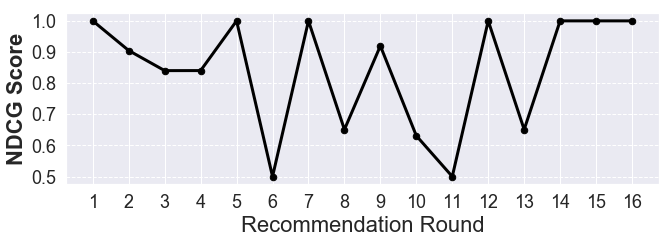

         | Avg num of recover | Avg explored round
VisGuide |1.6                 |12
Baseline |2.1                 |10
VisGuide  mean =  1.4482758620689655 , std =  0.8695732490526491
Baseline  mean =  2.619047619047619 , std =  2.2626595720833778


F_onewayResult(statistic=7.021428115328699, pvalue=0.00997801689013237)

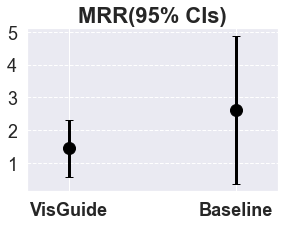

In [47]:
conditions = ["VisGuide","Baseline"]

result_NDCG = defaultdict(dict) # original NDCG
avg_round = {} # mean of recover round
avg_NDCG_score = {}
stat_info = defaultdict(dict) # avg num of recover round, avg explore round

for c in conditions:
    
    # read file
    data = readFile(c)

    # cal NDCG of each user
    NDCG_data = get_NDCG_data(data)
    result_NDCG[c] = NDCG_data

    if c == "VisGuide":
        draw_data = {key:value for key,value in NDCG_data.items() if key=="user_10_AQ.json"}
        drawUserNDCG(draw_data,"VisGuide")
    
    #### draw original NDCG of each user
    #drawUserNDCG(NDCG_data,c)
   
    # Store NDCG data
    avg_NDCG_score[c] = [NDCG for scores in NDCG_data.values() for NDCG in scores]
    
    # cal mean of recover rounds
    recover_round,stat_info[c]["avg_num_recover"],stat_info[c]["avg_explored_round"] = average_recover_rounds(NDCG_data)
    avg_round[c] = recover_round

# print statistic info
printStatInfo(stat_info)

# print error bar chart
drawErrorBar(avg_round,"MRR(95% CIs)","")
stats.kruskal(avg_round["VisGuide"],avg_round["Baseline"])
stats.f_oneway(avg_round["VisGuide"],avg_round["Baseline"])

## Cal Transfer performance --> study 2
* VisGuide (10 data points)
* Heuristic (10 data points)

KruskalResult(statistic=4.507110438729202, pvalue=0.03375421817675349)
KruskalResult(statistic=3.839860139860139, pvalue=0.05004769582253651)
KruskalResult(statistic=1.7917628945342572, pvalue=0.1807115192742513)
KruskalResult(statistic=5.2054794520547905, pvalue=0.022515804341787952)


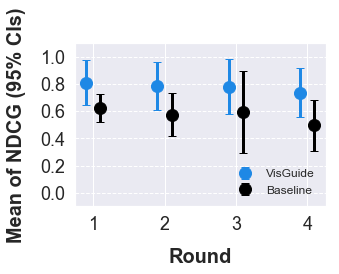

In [48]:
from pprint import pprint
transfer_conditions = ["VisGuide","Baseline"]

transfer_result = dict()
draw_data={}

for c in transfer_conditions:
    data = readFile(c+'/second') 
    
    # cal first four round result
    NDCG_data,user_data = transfer_max(data)
    transfer_result[c]= NDCG_data

# draw plot
drawTransfer(transfer_result)

# significance
draw_data = {
    "VisGuide_first":transfer_result["VisGuide"]["first"],
    "Baseline_first":transfer_result["Baseline"]["first"],
    "VisGuide_second":transfer_result["VisGuide"]["second"],
    "Baseline_second":transfer_result["Baseline"]["second"],
    "VisGuide_third":transfer_result["VisGuide"]["third"],
    "Baseline_third":transfer_result["Baseline"]["third"],
    "VisGuide_forth":transfer_result["VisGuide"]["forth"],
    "Baseline_forth":transfer_result["Baseline"]["forth"],
}
print(stats.kruskal(draw_data["VisGuide_first"],draw_data["Baseline_first"]))
print(stats.kruskal(draw_data["VisGuide_second"],draw_data["Baseline_second"]))
print(stats.kruskal(draw_data["VisGuide_third"],draw_data["Baseline_third"]))
print(stats.kruskal(draw_data["VisGuide_forth"],draw_data["Baseline_forth"]))

## Questioinnare - The motivation to the next chart / insightful of factors (CHI2020)

In [49]:
# read csv
user_rating = {}
with open('Questionnare_result.csv', "r",encoding="utf-8") as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for i,row in enumerate(rows):
        if i!=0: 
            user = row[1]
            data = [int(r) for r in row[2:]]
            user_rating[user] = data

Motivation
F_onewayResult(statistic=8.900316455696201, pvalue=0.005094233297958136)
F_onewayResult(statistic=9.687898089171975, pvalue=0.003623703378724119)
F_onewayResult(statistic=0.013975155279503102, pvalue=0.9065532293215635)
Insightful
F_onewayResult(statistic=9.775862068965514, pvalue=0.003490143558981194)
Dev   [3.3157894736842106]
Ins   [3.3157894736842106, 4.421052631578948]
Dev   [2.3684210526315788]
Ins   [2.3684210526315788, 3.6842105263157894]
Attr   [2.3684210526315788, 3.6842105263157894, 3.736842105263158]


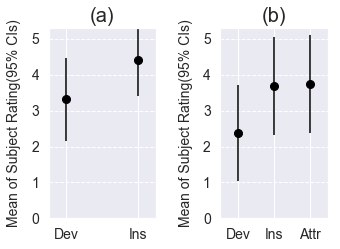

In [50]:
# the motivation to the next chart
# Q2,Q3
datas=[
    {
        "Dev":[value[1] for key,value in user_rating.items()],
        "Ins":[value[3] for key,value in user_rating.items()]
    },
    {
        "Dev":[value[2] for key,value in user_rating.items()],
        "Ins":[value[4] for key,value in user_rating.items()],
        "Attr":[value[5] for key,value in user_rating.items()]
    }
]
print("Motivation")
print(stats.f_oneway(datas[1]["Dev"],datas[1]["Ins"]))
print(stats.f_oneway(datas[1]["Dev"],datas[1]["Attr"]))
print(stats.f_oneway(datas[1]["Ins"],datas[1]["Attr"]))
print("===========================================================================")

# How chart factors help users identify interesting events
# Q2-1 ,Q3-1, Q3-2
print("Insightful")
print(stats.f_oneway(datas[0]["Dev"],datas[0]["Ins"]))
print("===========================================================================")

# draw img
fig = plt.figure(figsize=(5, 3.5))
fig.subplots_adjust(wspace=0.6)

draw_data=[]
for data in datas:
    temp = defaultdict(list)
    for condition,values in data.items():
        temp["mean"].append(scipy.mean(values))
        temp["std"].append(statistics.stdev(values))
        print(condition," ", temp["mean"])
    draw_data.append(temp)
    

for i,data in enumerate(draw_data):
    ax1 = plt.subplot(1,2,i+1)
    plt.ylim([0,5.3])
    ax1.set_ylabel("Mean of Subject Rating(95% CIs)",fontsize=14,labelpad=10)
    if i==0:
        
        plt.title("(a)",fontsize=20)
    else:
        plt.title("(b)",fontsize=20)
    ax1.margins(0.25, None)
    ind = np.arange(len(data["mean"]))+1  
    width = 0.2  # the width of the bars

    plt.yticks([0.0,1.0,2.0,3.0,4.0,5.0],fontsize=14)
    plt.xticks(ind,fontsize=14)
    ax1.set_xticklabels(list(datas[i].keys()))
    plt.grid(linestyle='--',axis="y")
        
    #for condition,data in result.items():
    ax1.errorbar(ind , np.array(data["mean"]),np.array(data["std"]),color="#000000",marker="o",fmt="o",markersize=8)

plt.savefig('figure\\factor_rating.png',dpi=300)

## Questionnare - Performance --> study 1

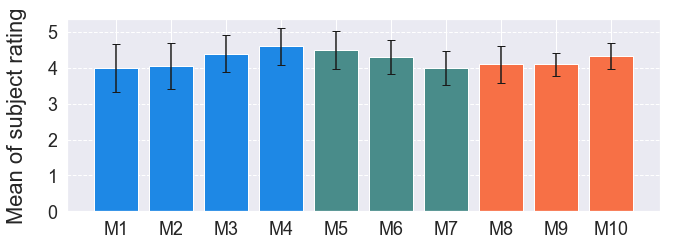

In [51]:
visgudie = {"7","10","2","9","14","18","19","8","24","22"}

vis_datas = {
    "Visual":{
        'Tree colors':[value[0] for key,value in user_rating.items() if key in visgudie],#Q1
        'Insightful':[scipy.mean([value[1],value[3]]) for key,value in user_rating.items()if key in visgudie],#Q2,3
        'Readibility':[value[6] for key,value in user_rating.items()if key in visgudie],#Q4
        'Flexibility':[value[7] for key,value in user_rating.items()if key in visgudie],#Q5
    },
    "Content":{
        "Comprehensive":[value[8] for key,value in user_rating.items()if key in visgudie], #Q6
        "Insightful":[scipy.mean([value[9],value[10]]) for key,value in user_rating.items()if key in visgudie],#Q7,8
        "Quality":[value[11] for key,value in user_rating.items()if key in visgudie], #Q9
    },
    "System":{
        "Guidance":[scipy.mean([value[12],value[13]]) for key,value in user_rating.items()if key in visgudie], #Q10,11
        "Usability":[scipy.mean([value[14],value[15]]) for key,value in user_rating.items()if key in visgudie],#Q12,13
        "Useful":[scipy.mean([value[16],value[17],value[18]]) for key,value in user_rating.items()if key in visgudie],#Q14,15,16
    }
}


drawBar(vis_datas,"Mean of subject rating")

# PCA on Models(appendix)

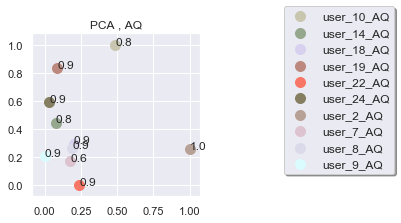

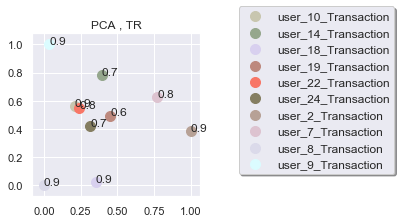

In [52]:
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import manifold, datasets

### NDCG scores
# read file
data = readFile("VisGuide\\all")

# cal NDCG of each user
NDCG_data = get_NDCG_data(data)

conditions = ["AQ","TR"]
colors = ["#C8C6AF","#95A78D","#D8D0EF","#BD897E","#F87666","#857E61","#B7A196","#DDC3D0","#DBDAEA","#DBFCFF"]

for c in conditions:

    models,users = read_pickles("Model/"+c+"/")
   
    X = np.array([model.coef_ for user,model in models.items()])
    NDCGs = np.array([np.round(np.mean(np.array(NDCG_data[user.split('.')[0]+'.json'])),1) for user,model in models.items()])
                    
    pca = PCA(n_components=2)
    X_PCA = pca.fit_transform(X)
    
    
    # draw plot
    x_min, x_max = X_PCA.min(0), X_PCA.max(0)
    X_norm = (X_PCA - x_min) / (x_max - x_min)  # 归一化
    
    
    plt.figure(figsize=(3, 3))
    for i in range(X_norm.shape[0]):
        plt.scatter(X_norm[i, 0], X_norm[i, 1],s=100,c = colors[i],label=users[i].split('.')[0])
        plt.annotate(str(NDCGs[i]),xy=(X_norm[i, 0],X_norm[i, 1]))
    
    plt.title("PCA , "+c)    
    plt.legend(loc='lower right', bbox_to_anchor=(2.2, 0.1), shadow=True, ncol=1,fontsize=12)
    
    plt.savefig('figure\\model_'+c+'.png',dpi=300)
    plt.savefig('figure\\model_'+c+'.pdf',dpi=300)
    
    plt.show()


# Feature importance (appendix)

(10, 186)
(10, 226)


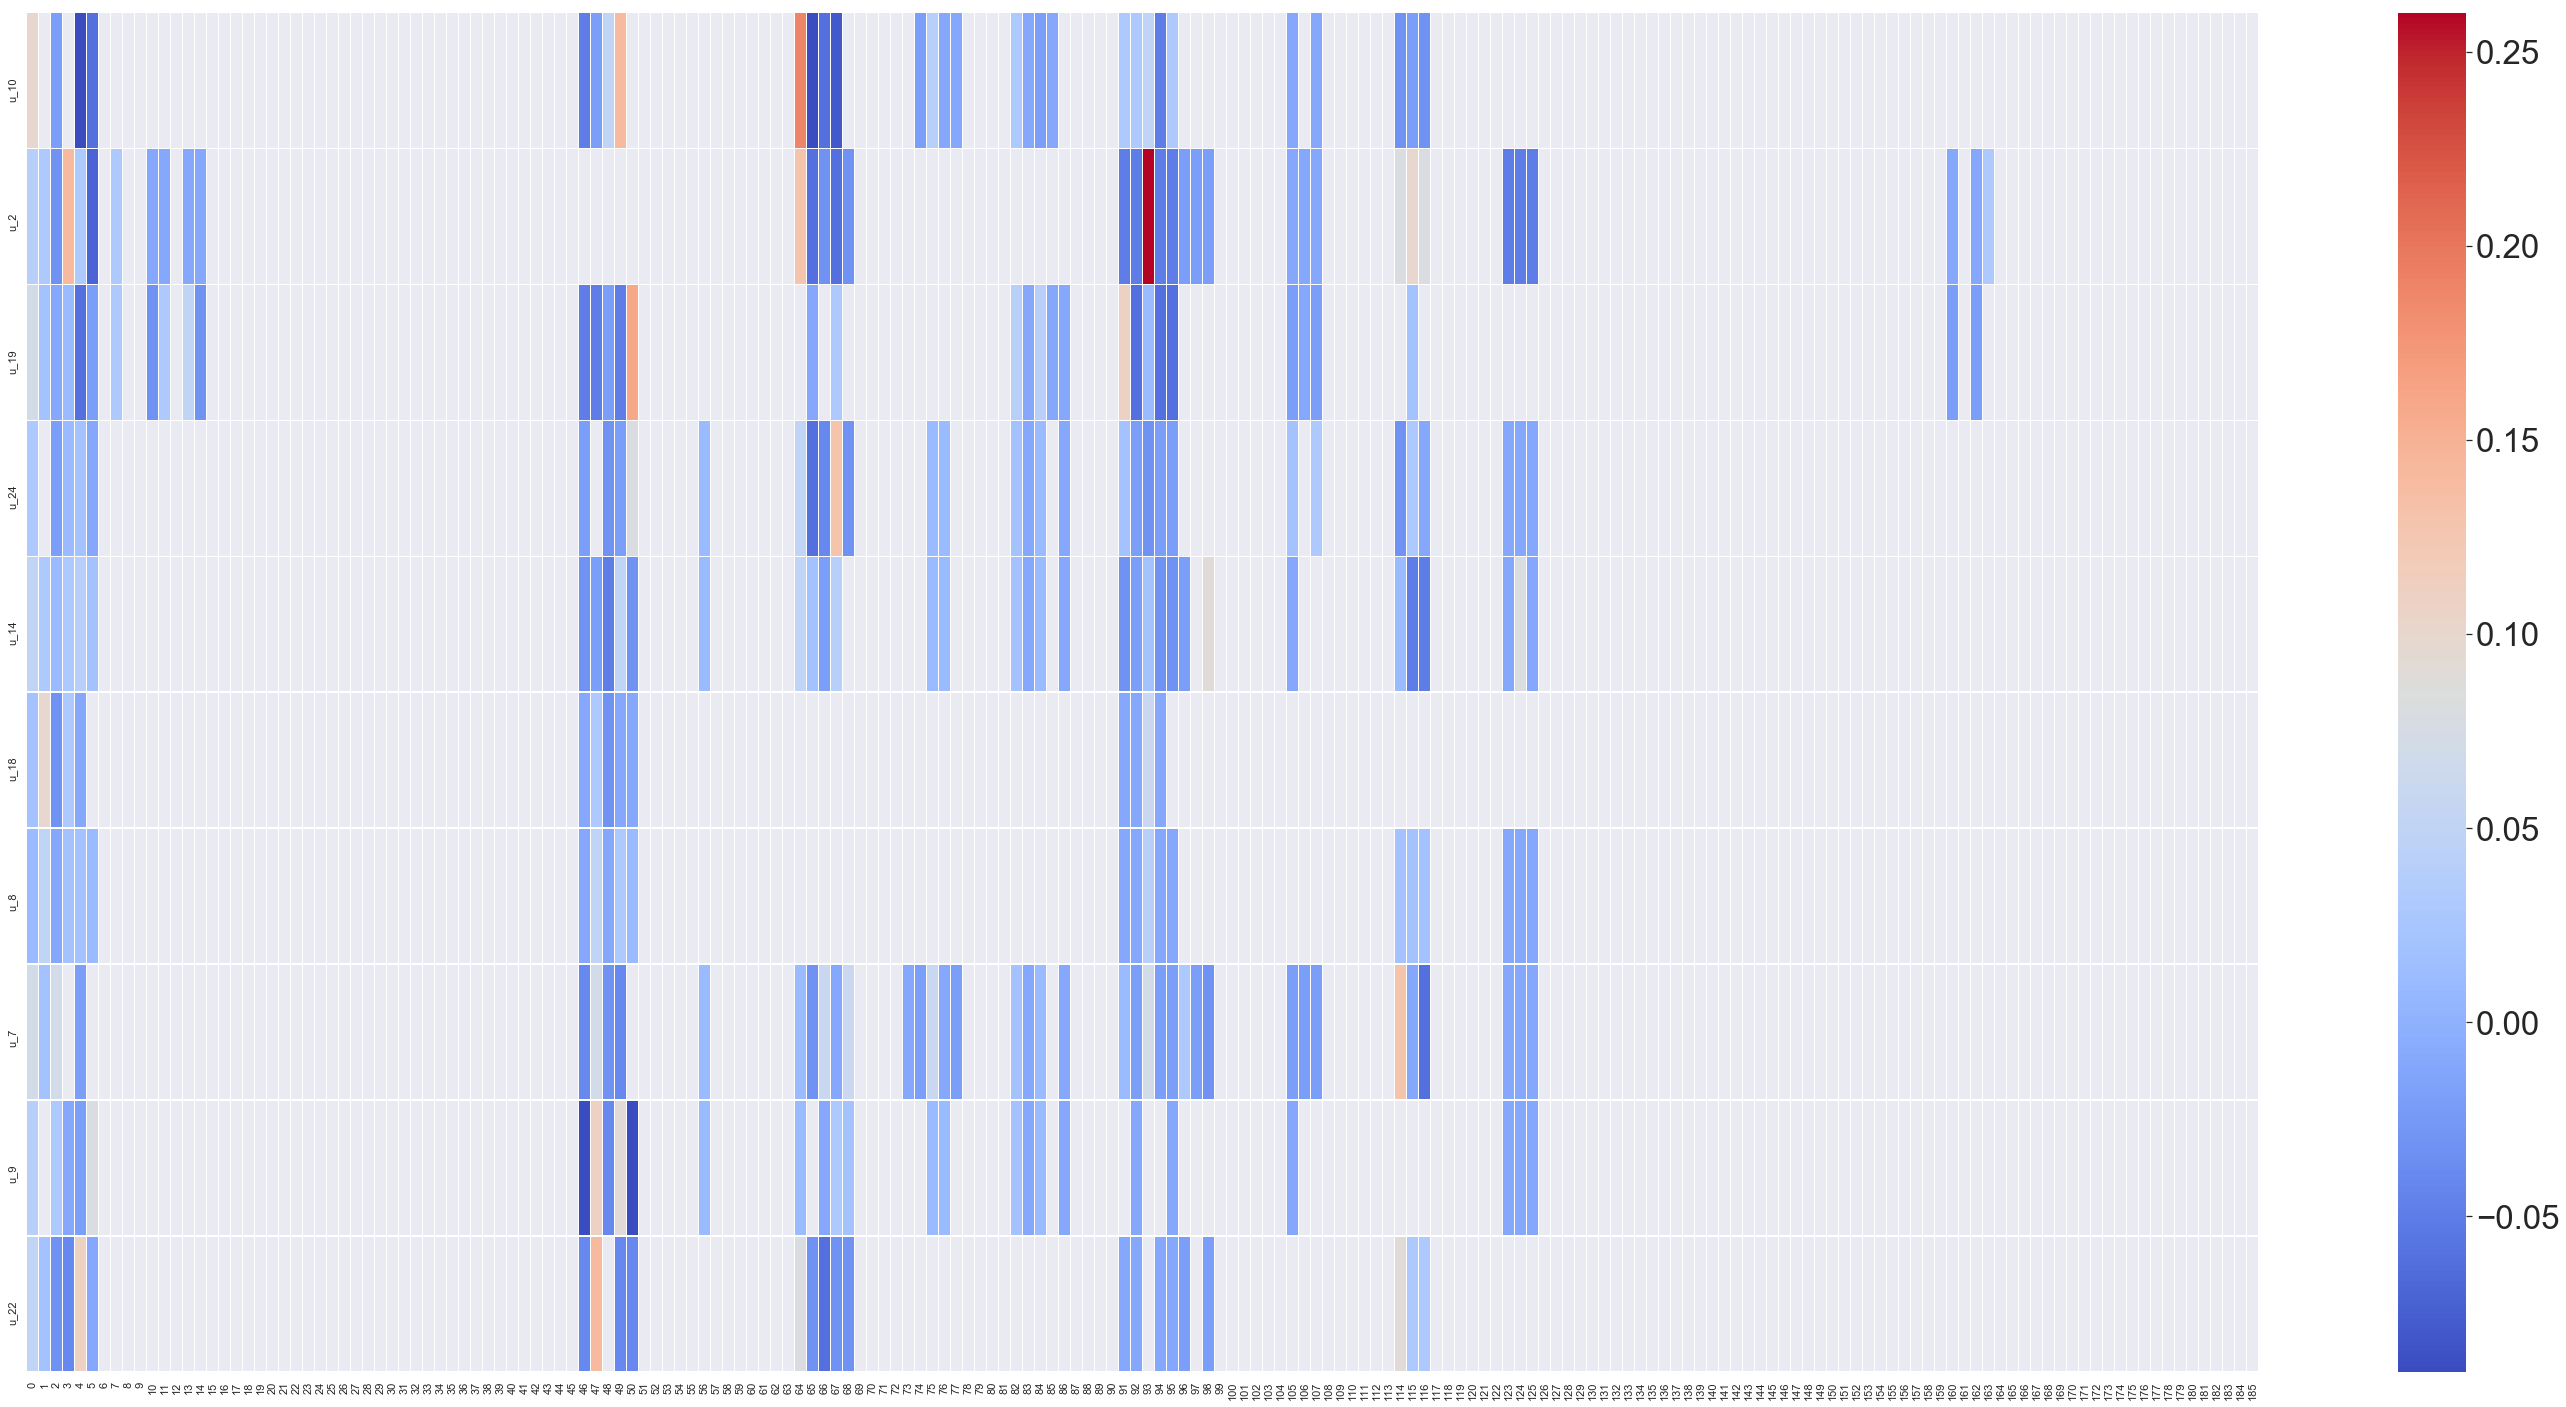

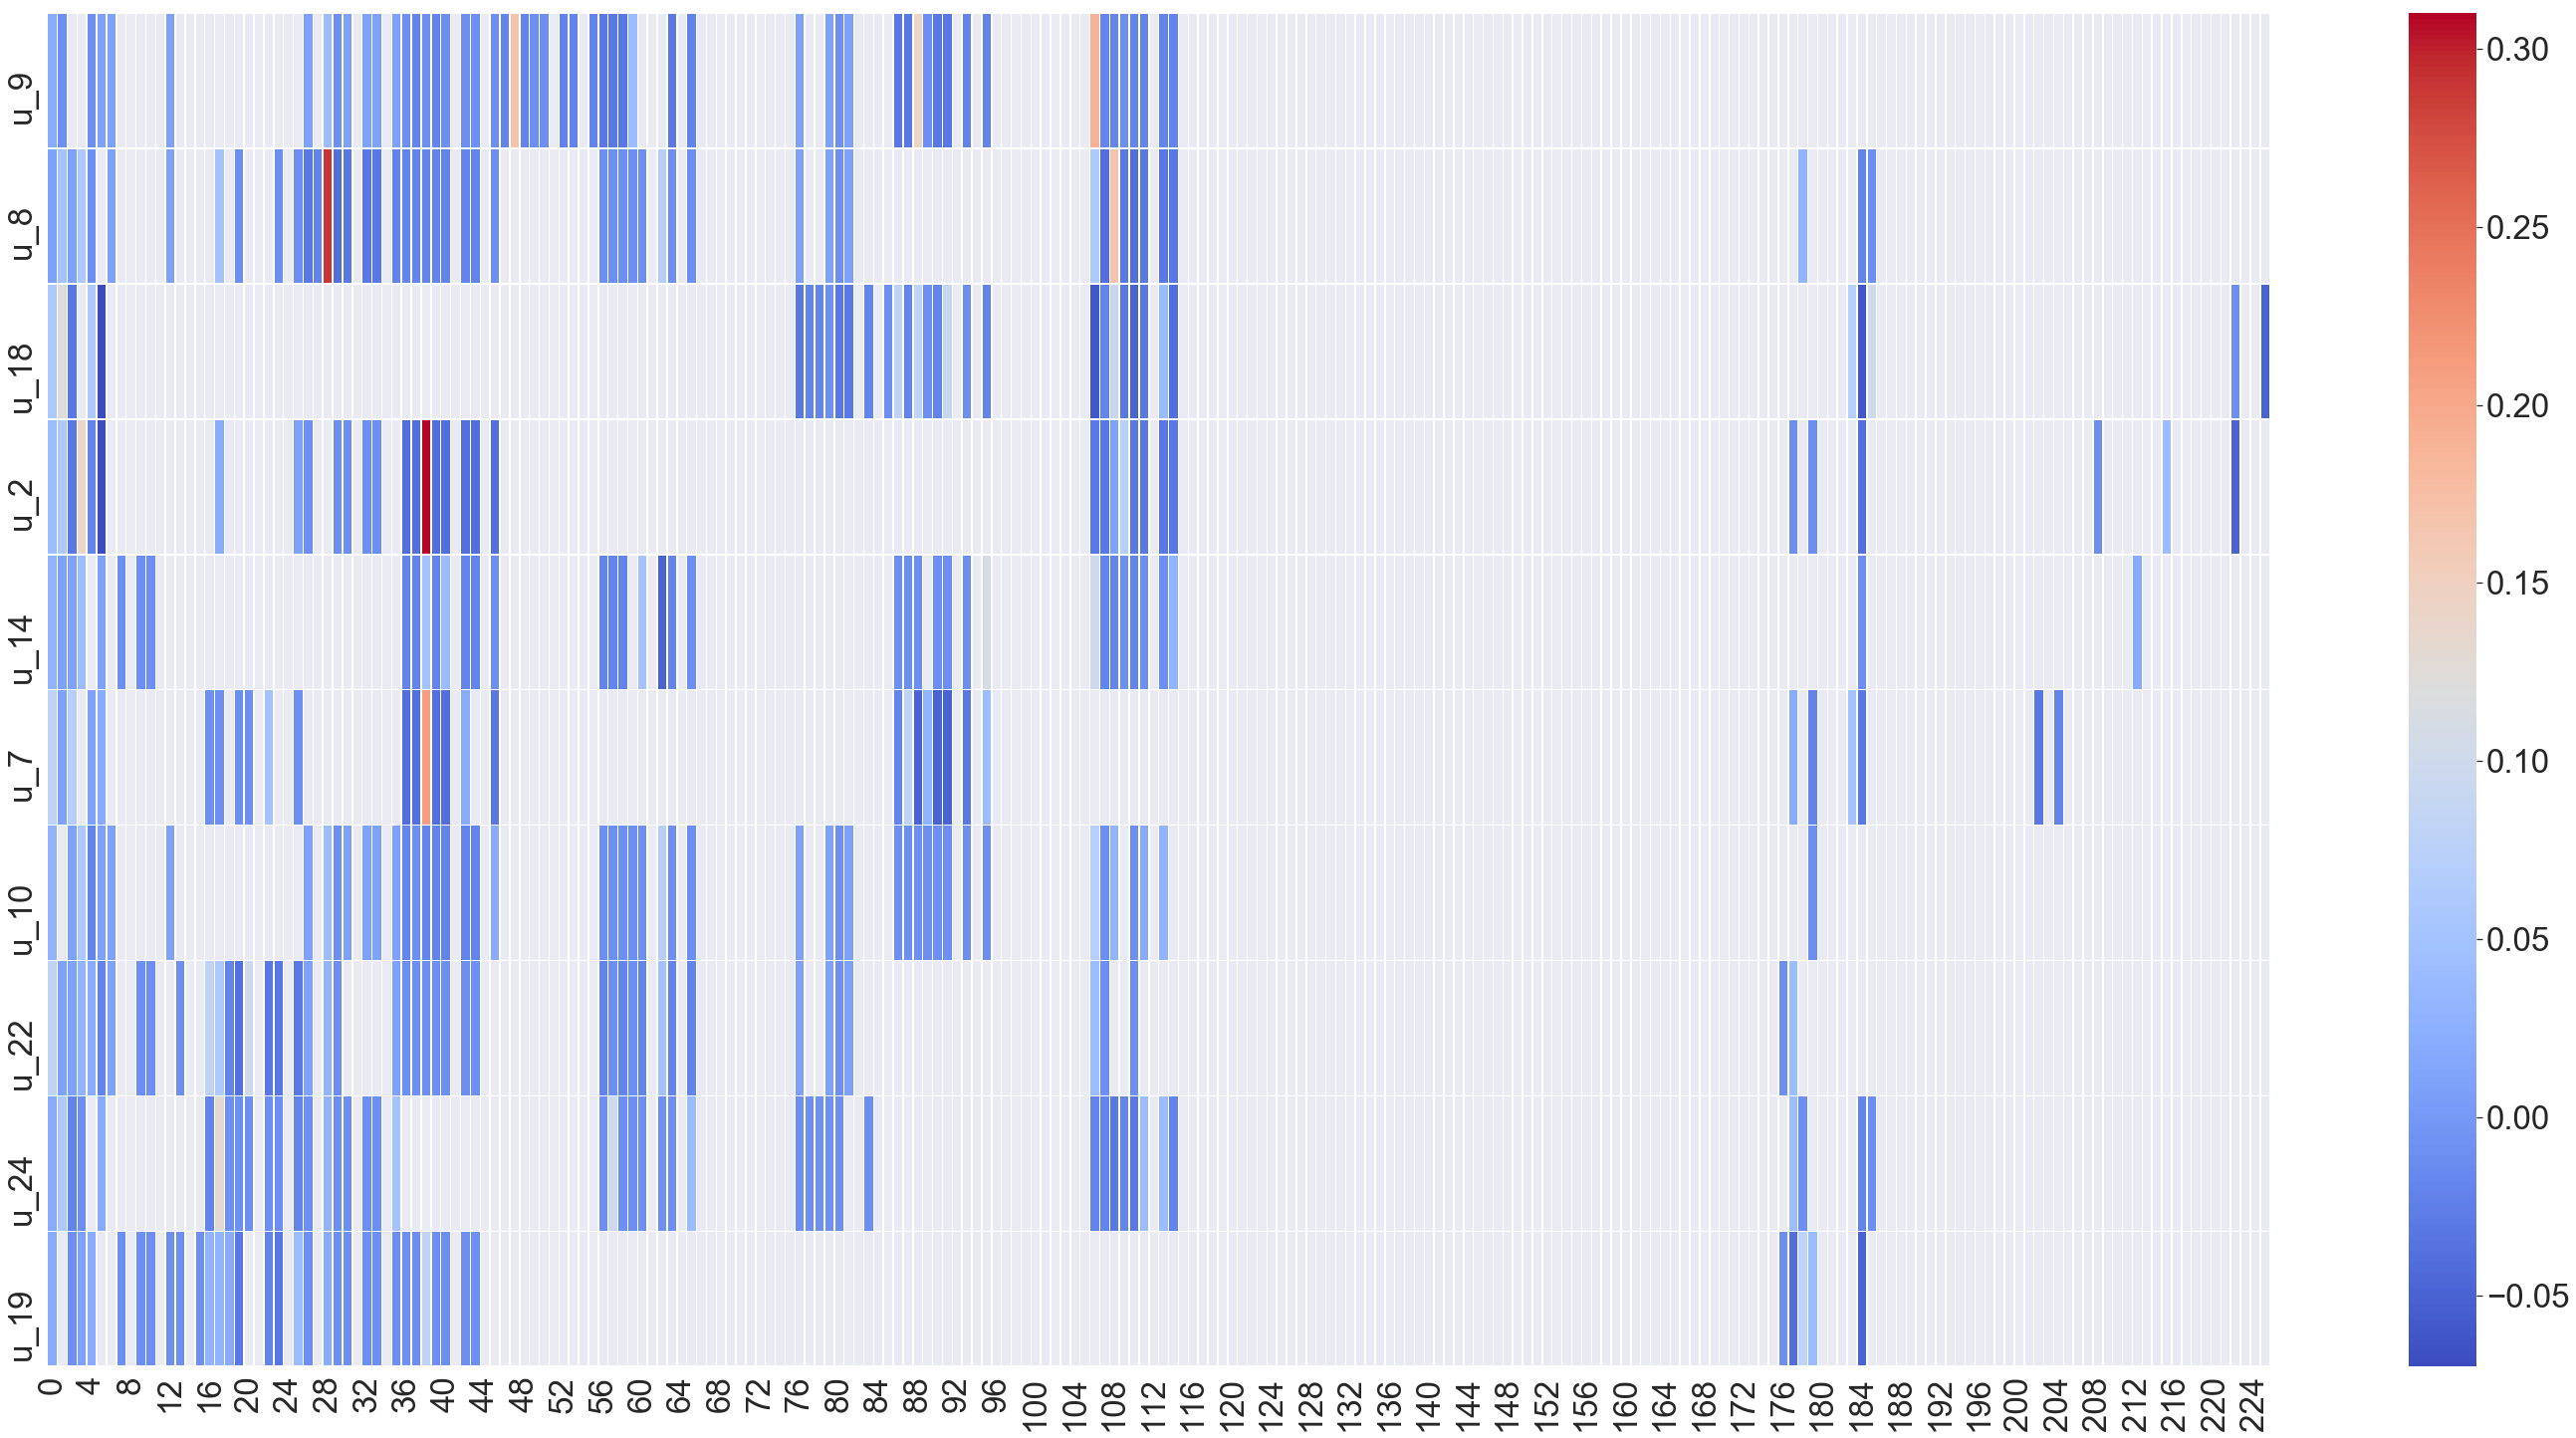

In [53]:
# Heatmap (no specific center)
conditions = ["AQ","TR"]
sort = {
    "AQ":['u_10','u_2','u_19','u_24','u_14','u_18','u_8','u_7','u_9','u_22'],
    "TR":['u_9','u_8','u_18','u_2','u_14','u_7','u_10','u_22','u_24','u_19']
}
for c in conditions:
    models,users = read_pickles("Model/"+c+"/")
    
    cond = "Transaction" if c =='TR' else c
    X = np.array([np.round(models["user_"+user.split('_')[1]+'_'+cond+'.pickle'].coef_,2) for user in sort[c]])
    
    mask = np.where(X!=0.0, 0.0, 1.0) 
    print(X.shape)
    
    fig, ax = plt.subplots(figsize=(50,25)) 
    sns.set(font_scale=3)
    
    sns.heatmap(X,linewidths=.5,cmap="coolwarm",yticklabels=sort[c],mask=mask)

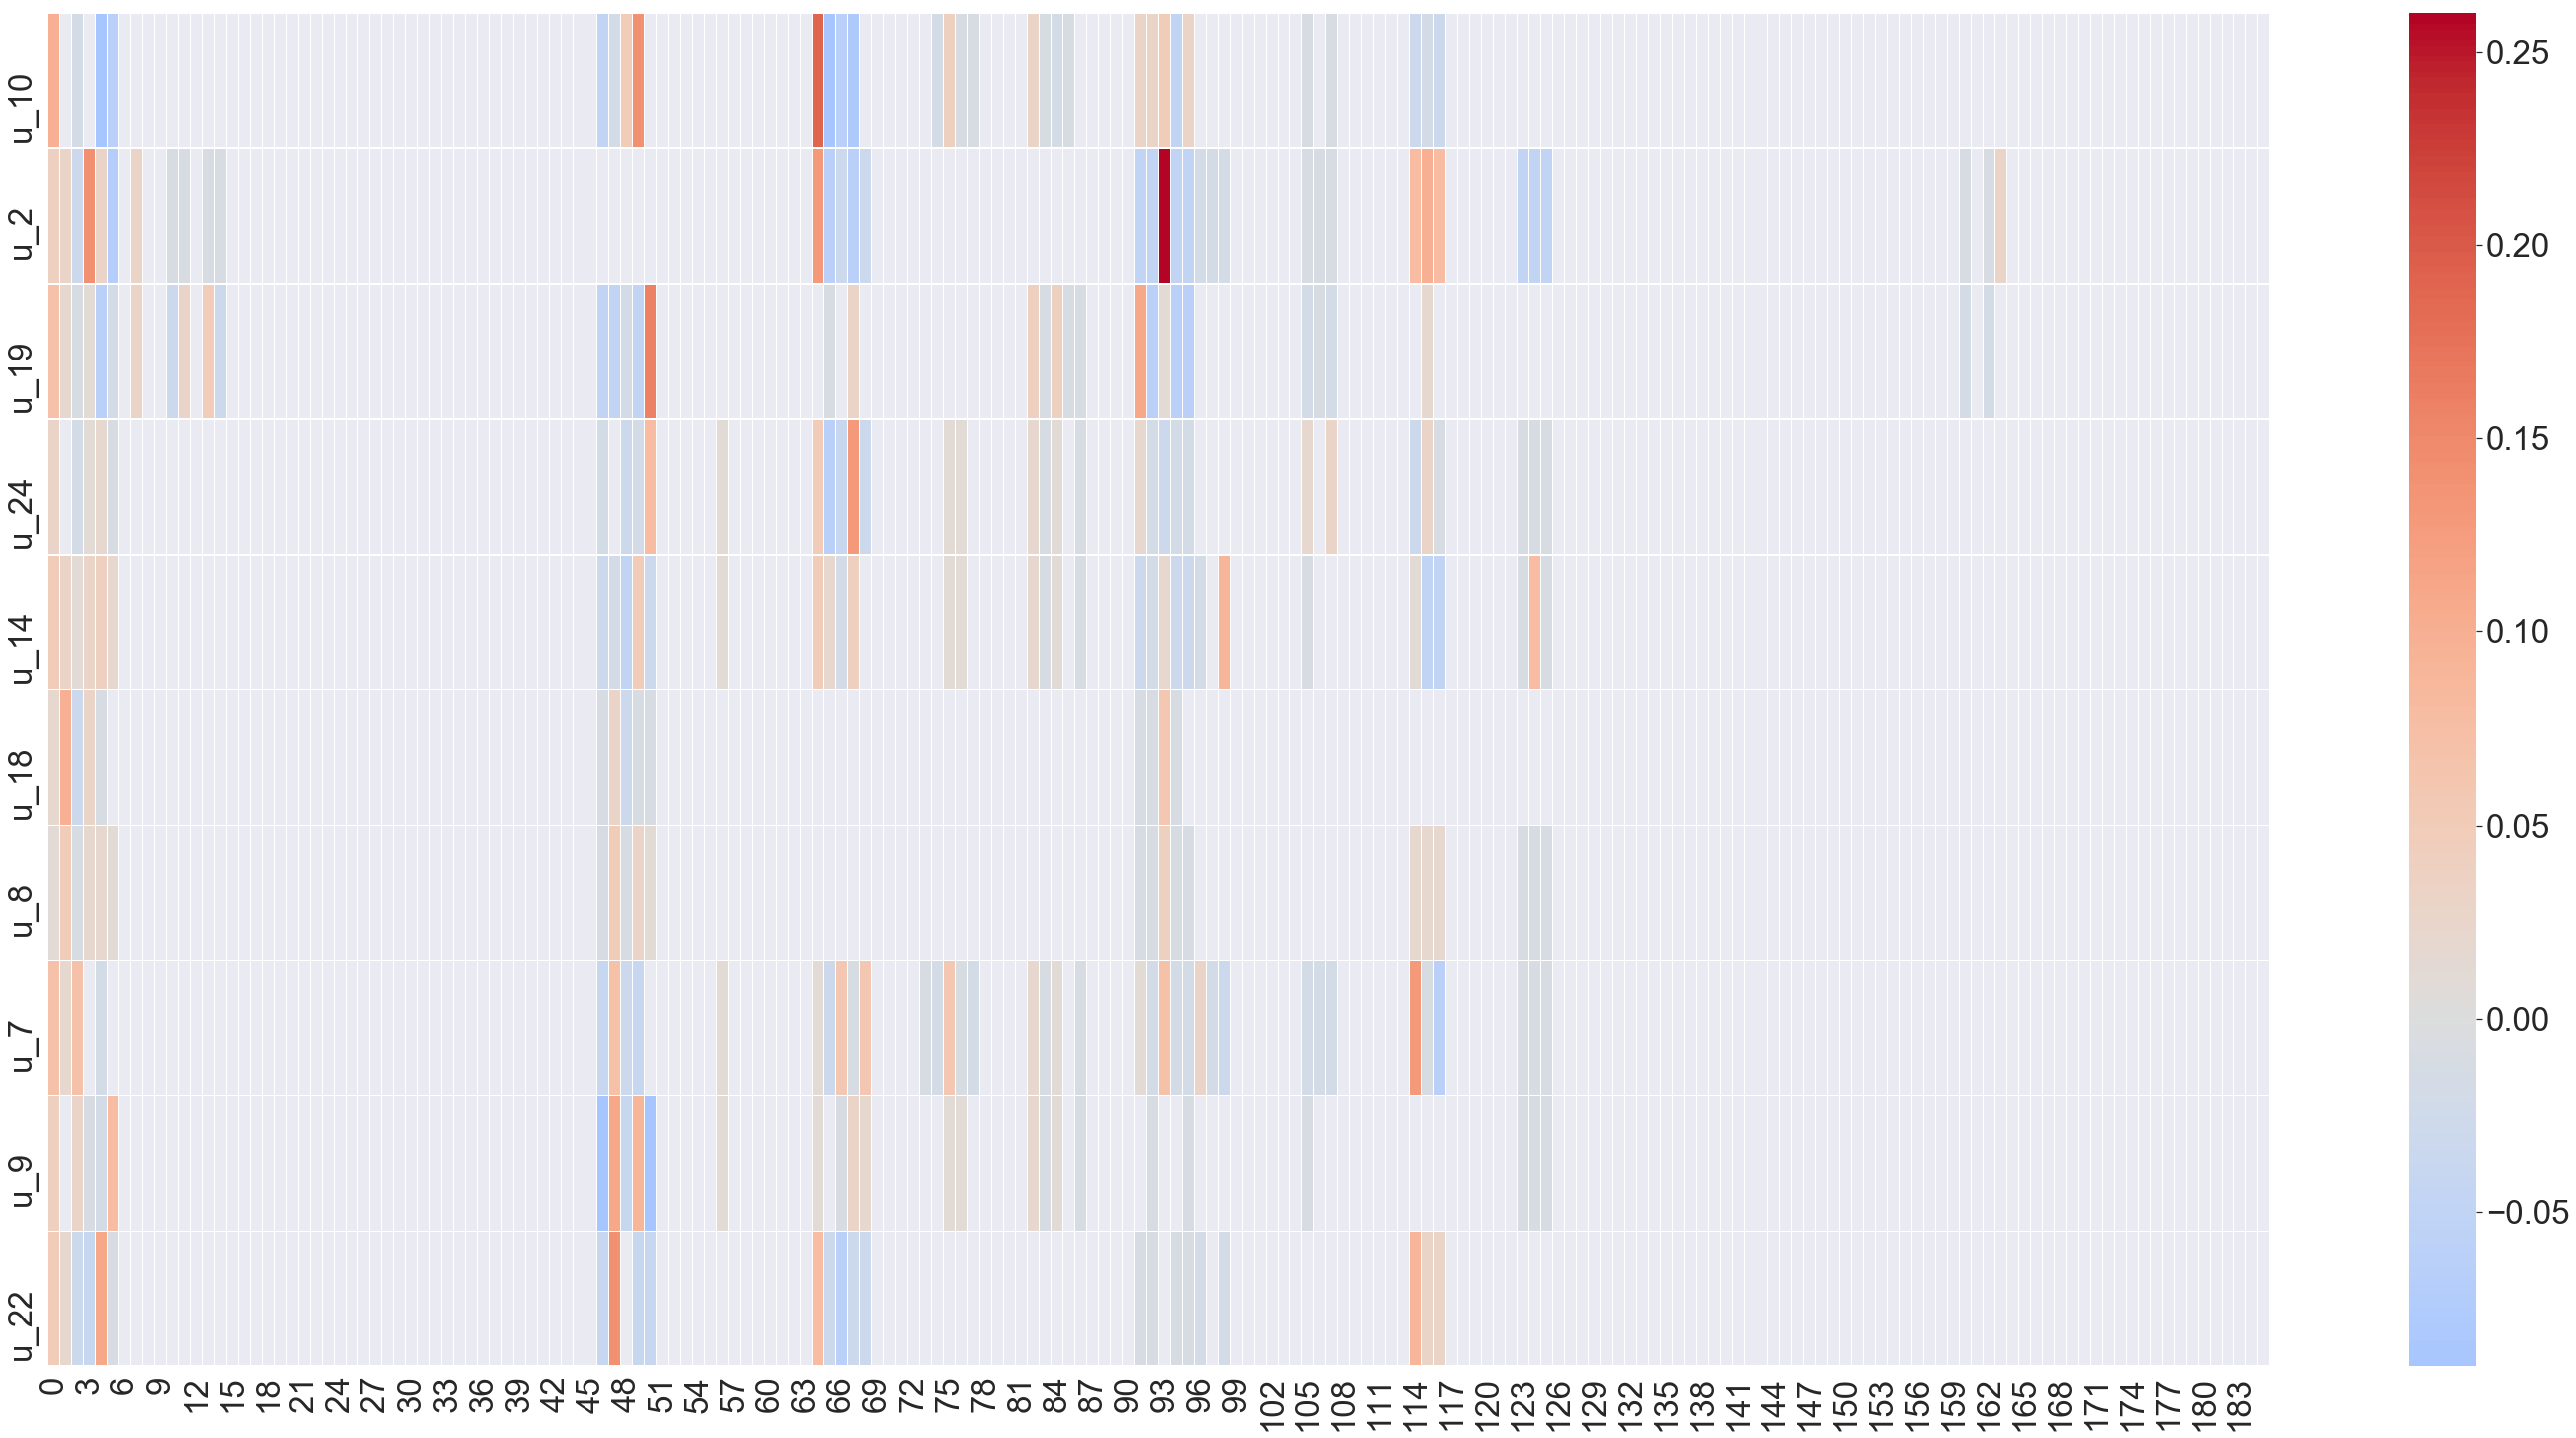

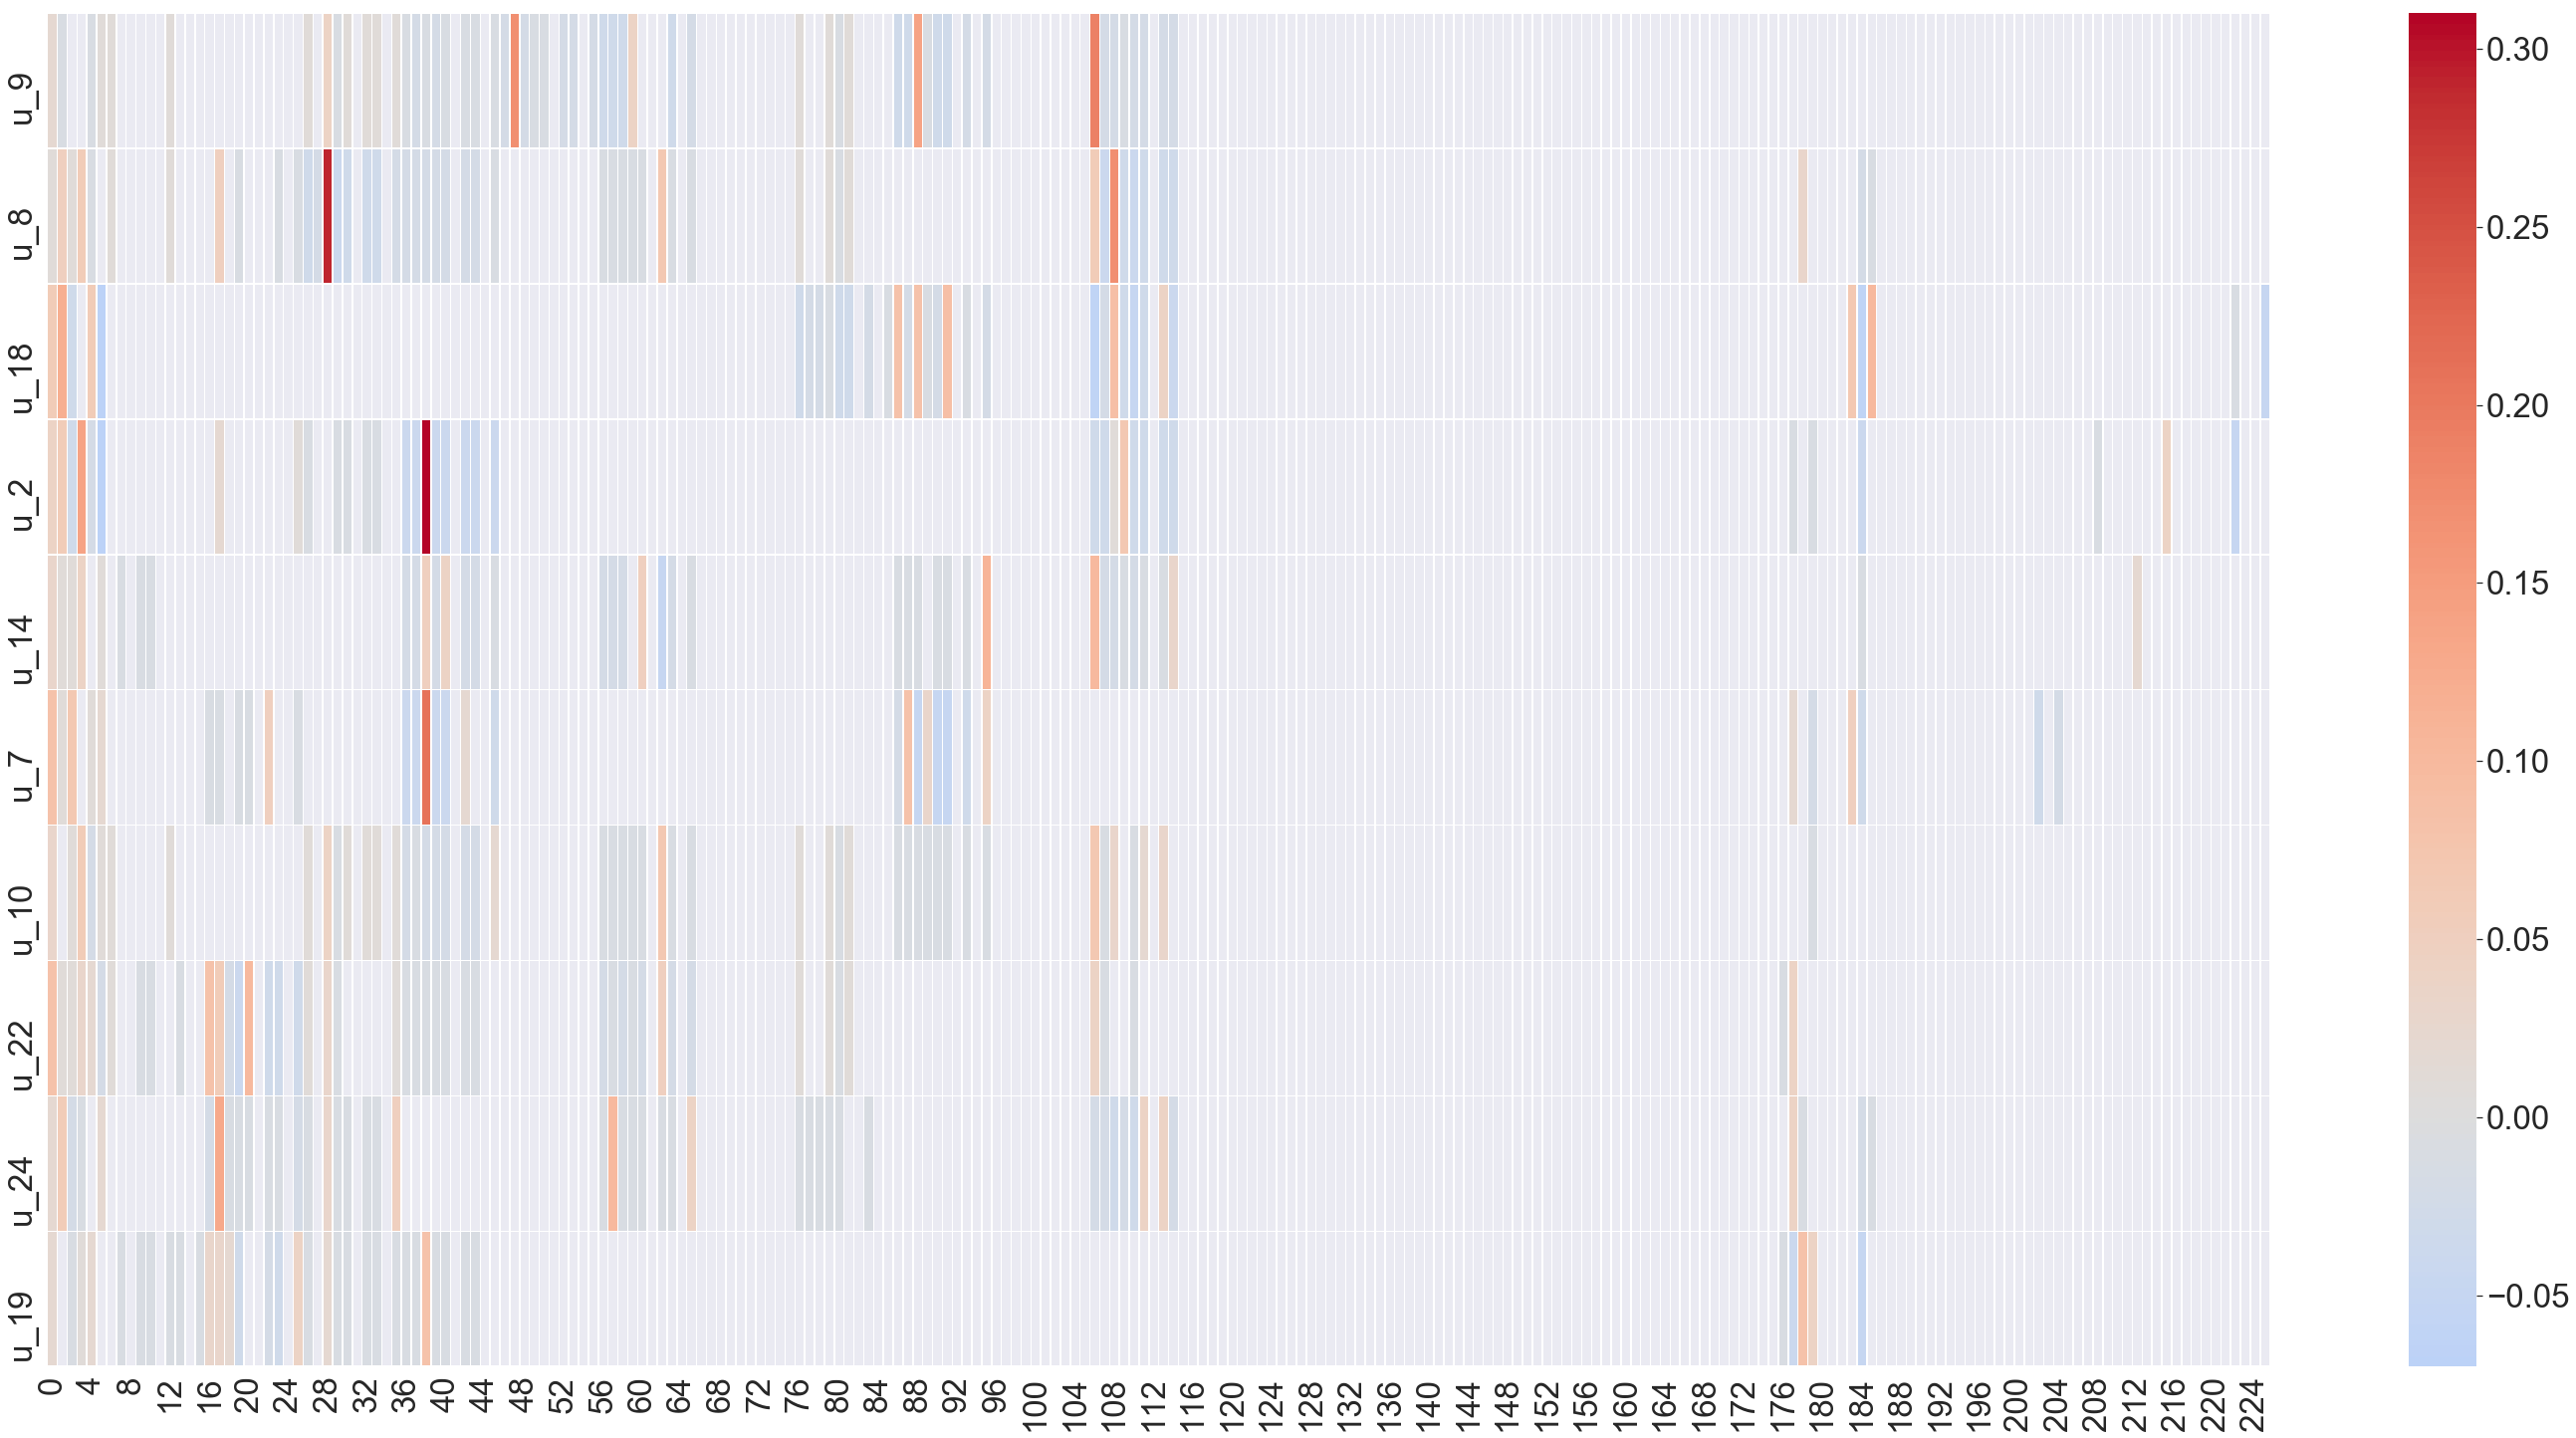

In [54]:
# Heatmap (center = 0.0)
for c in conditions:
    models,users = read_pickles("Model/"+c+"/")

    cond = "Transaction" if c =='TR' else c
    X = np.array([np.round(models["user_"+user.split('_')[1]+'_'+cond+'.pickle'].coef_,2) for user in sort[c]])
    
    mask = np.where(X!=0.0, 0.0, 1.0) 

    fig, ax = plt.subplots(figsize=(50,25)) 
    sns.set(font_scale=3)
    sns.heatmap(X,linewidths=.5,cmap="coolwarm",yticklabels=sort[c],mask=mask,center=0.0)
    

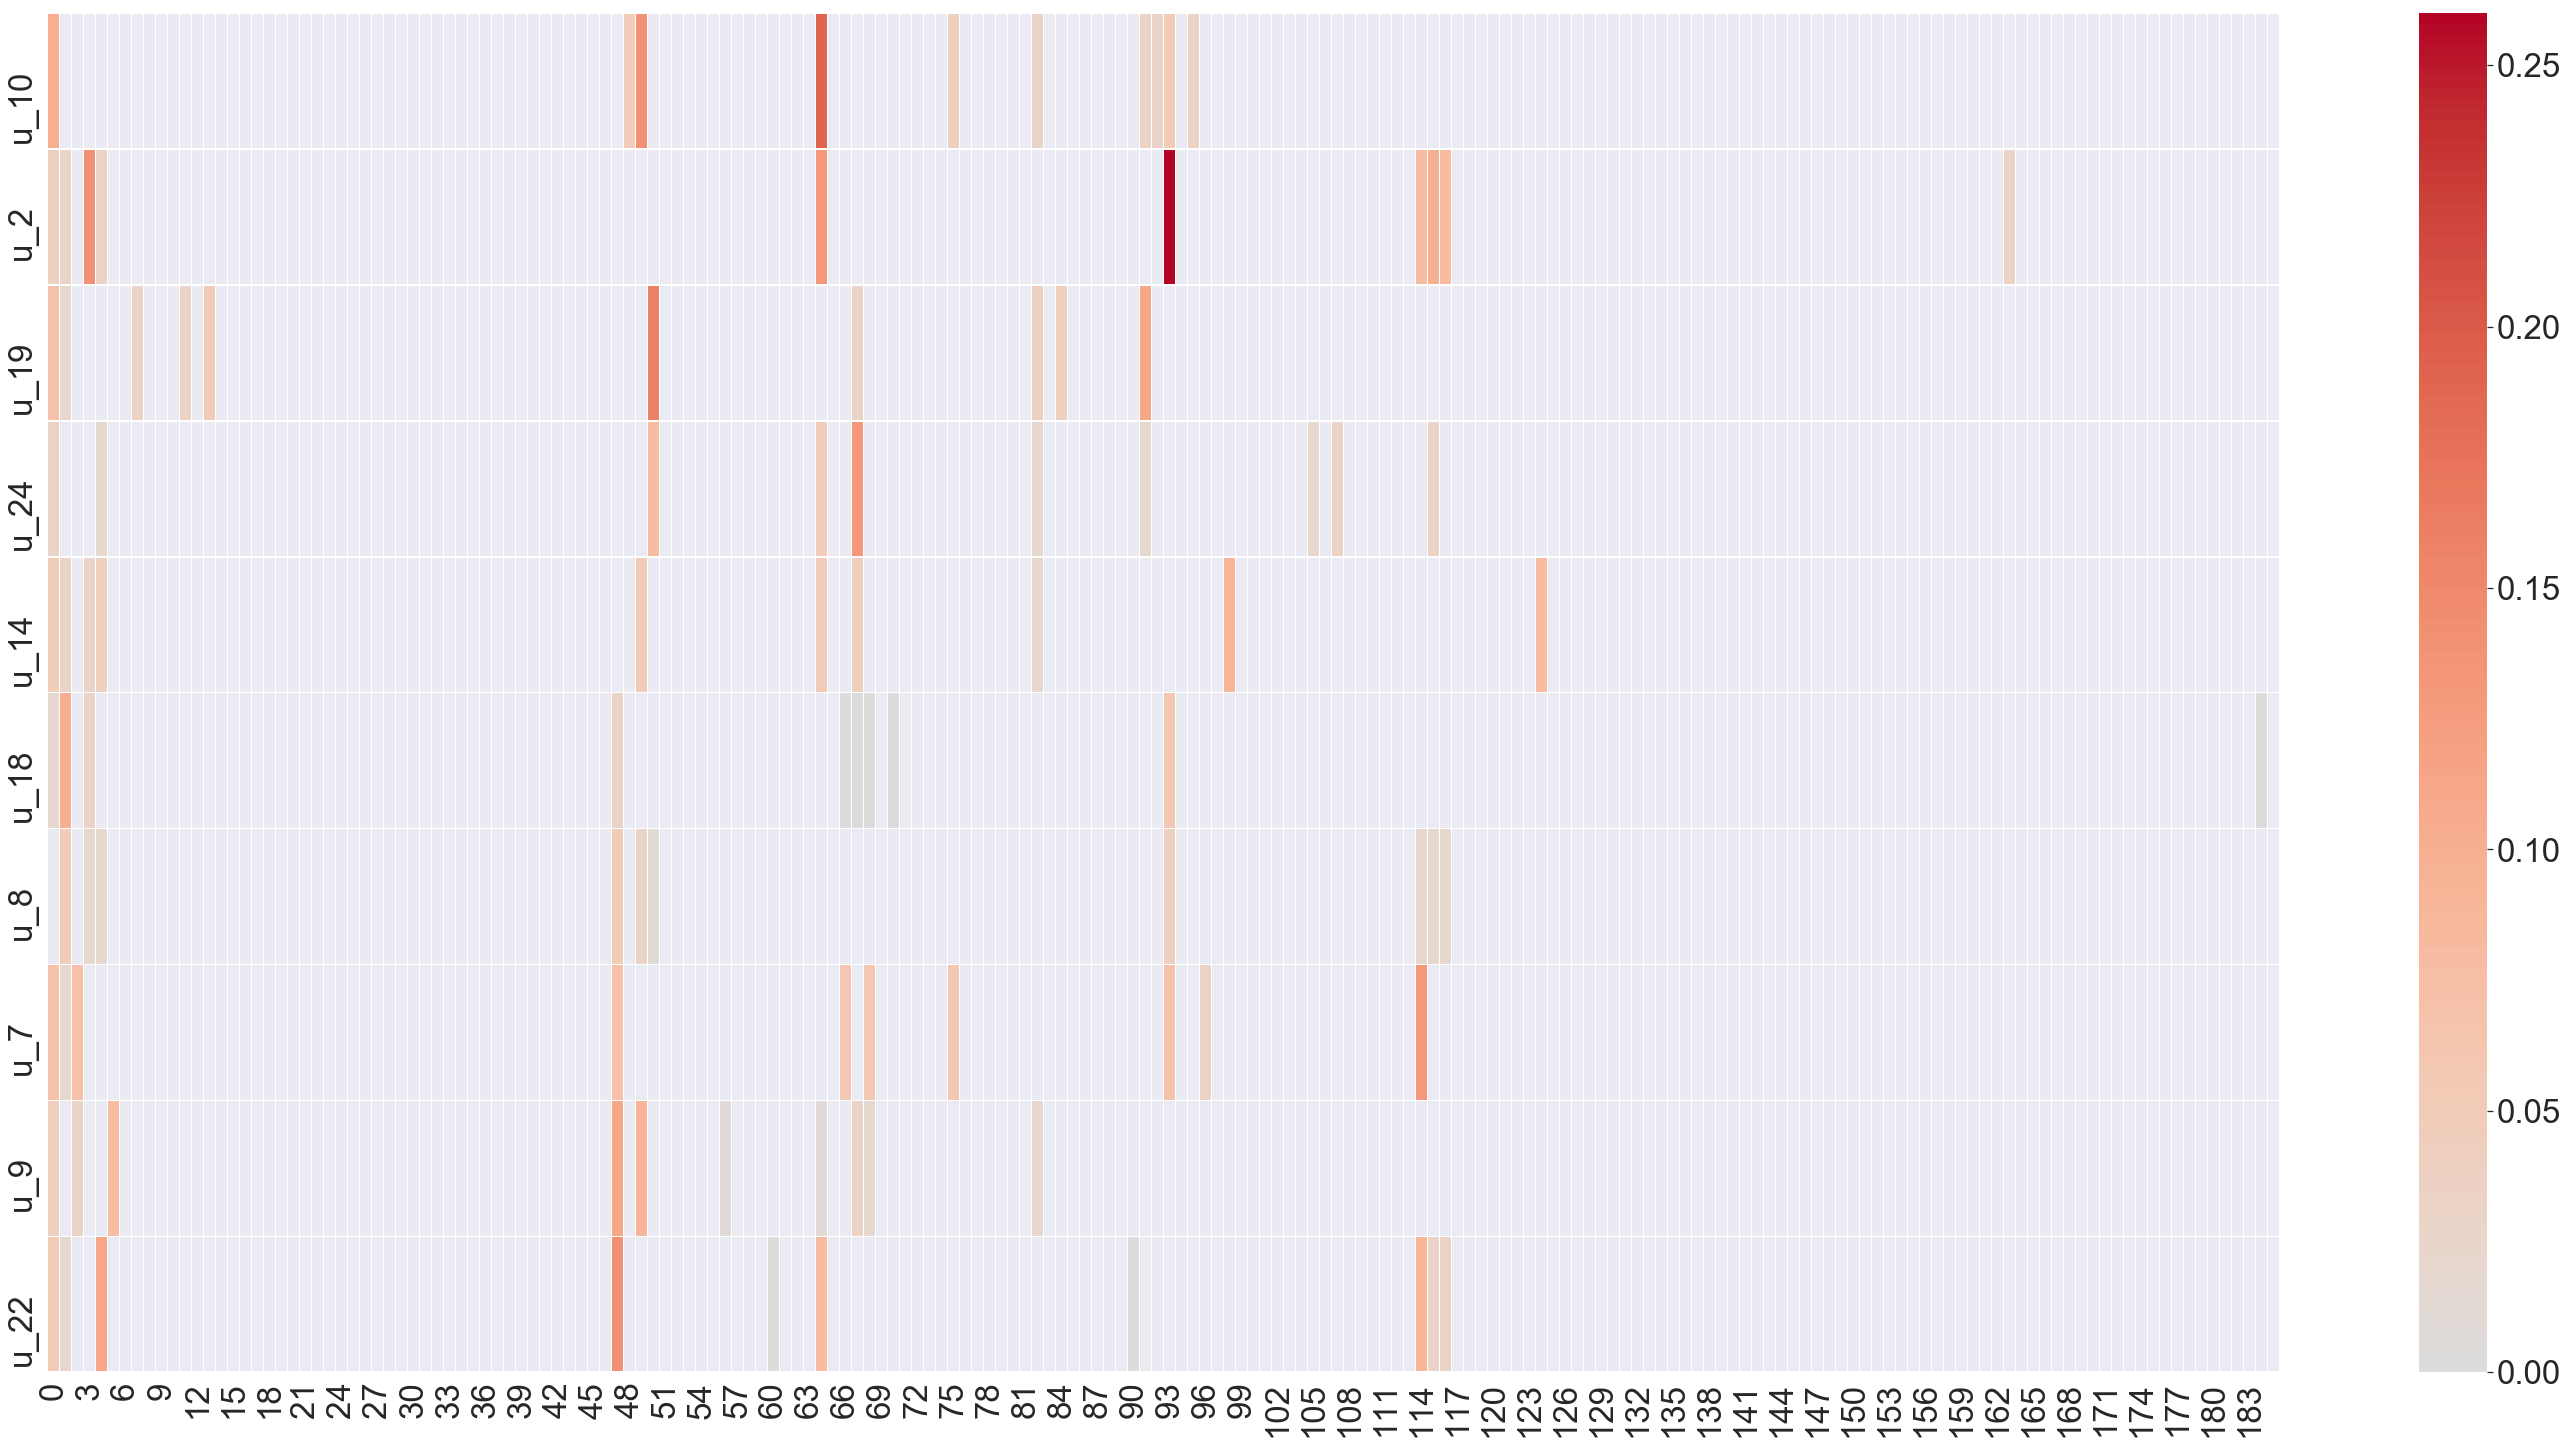

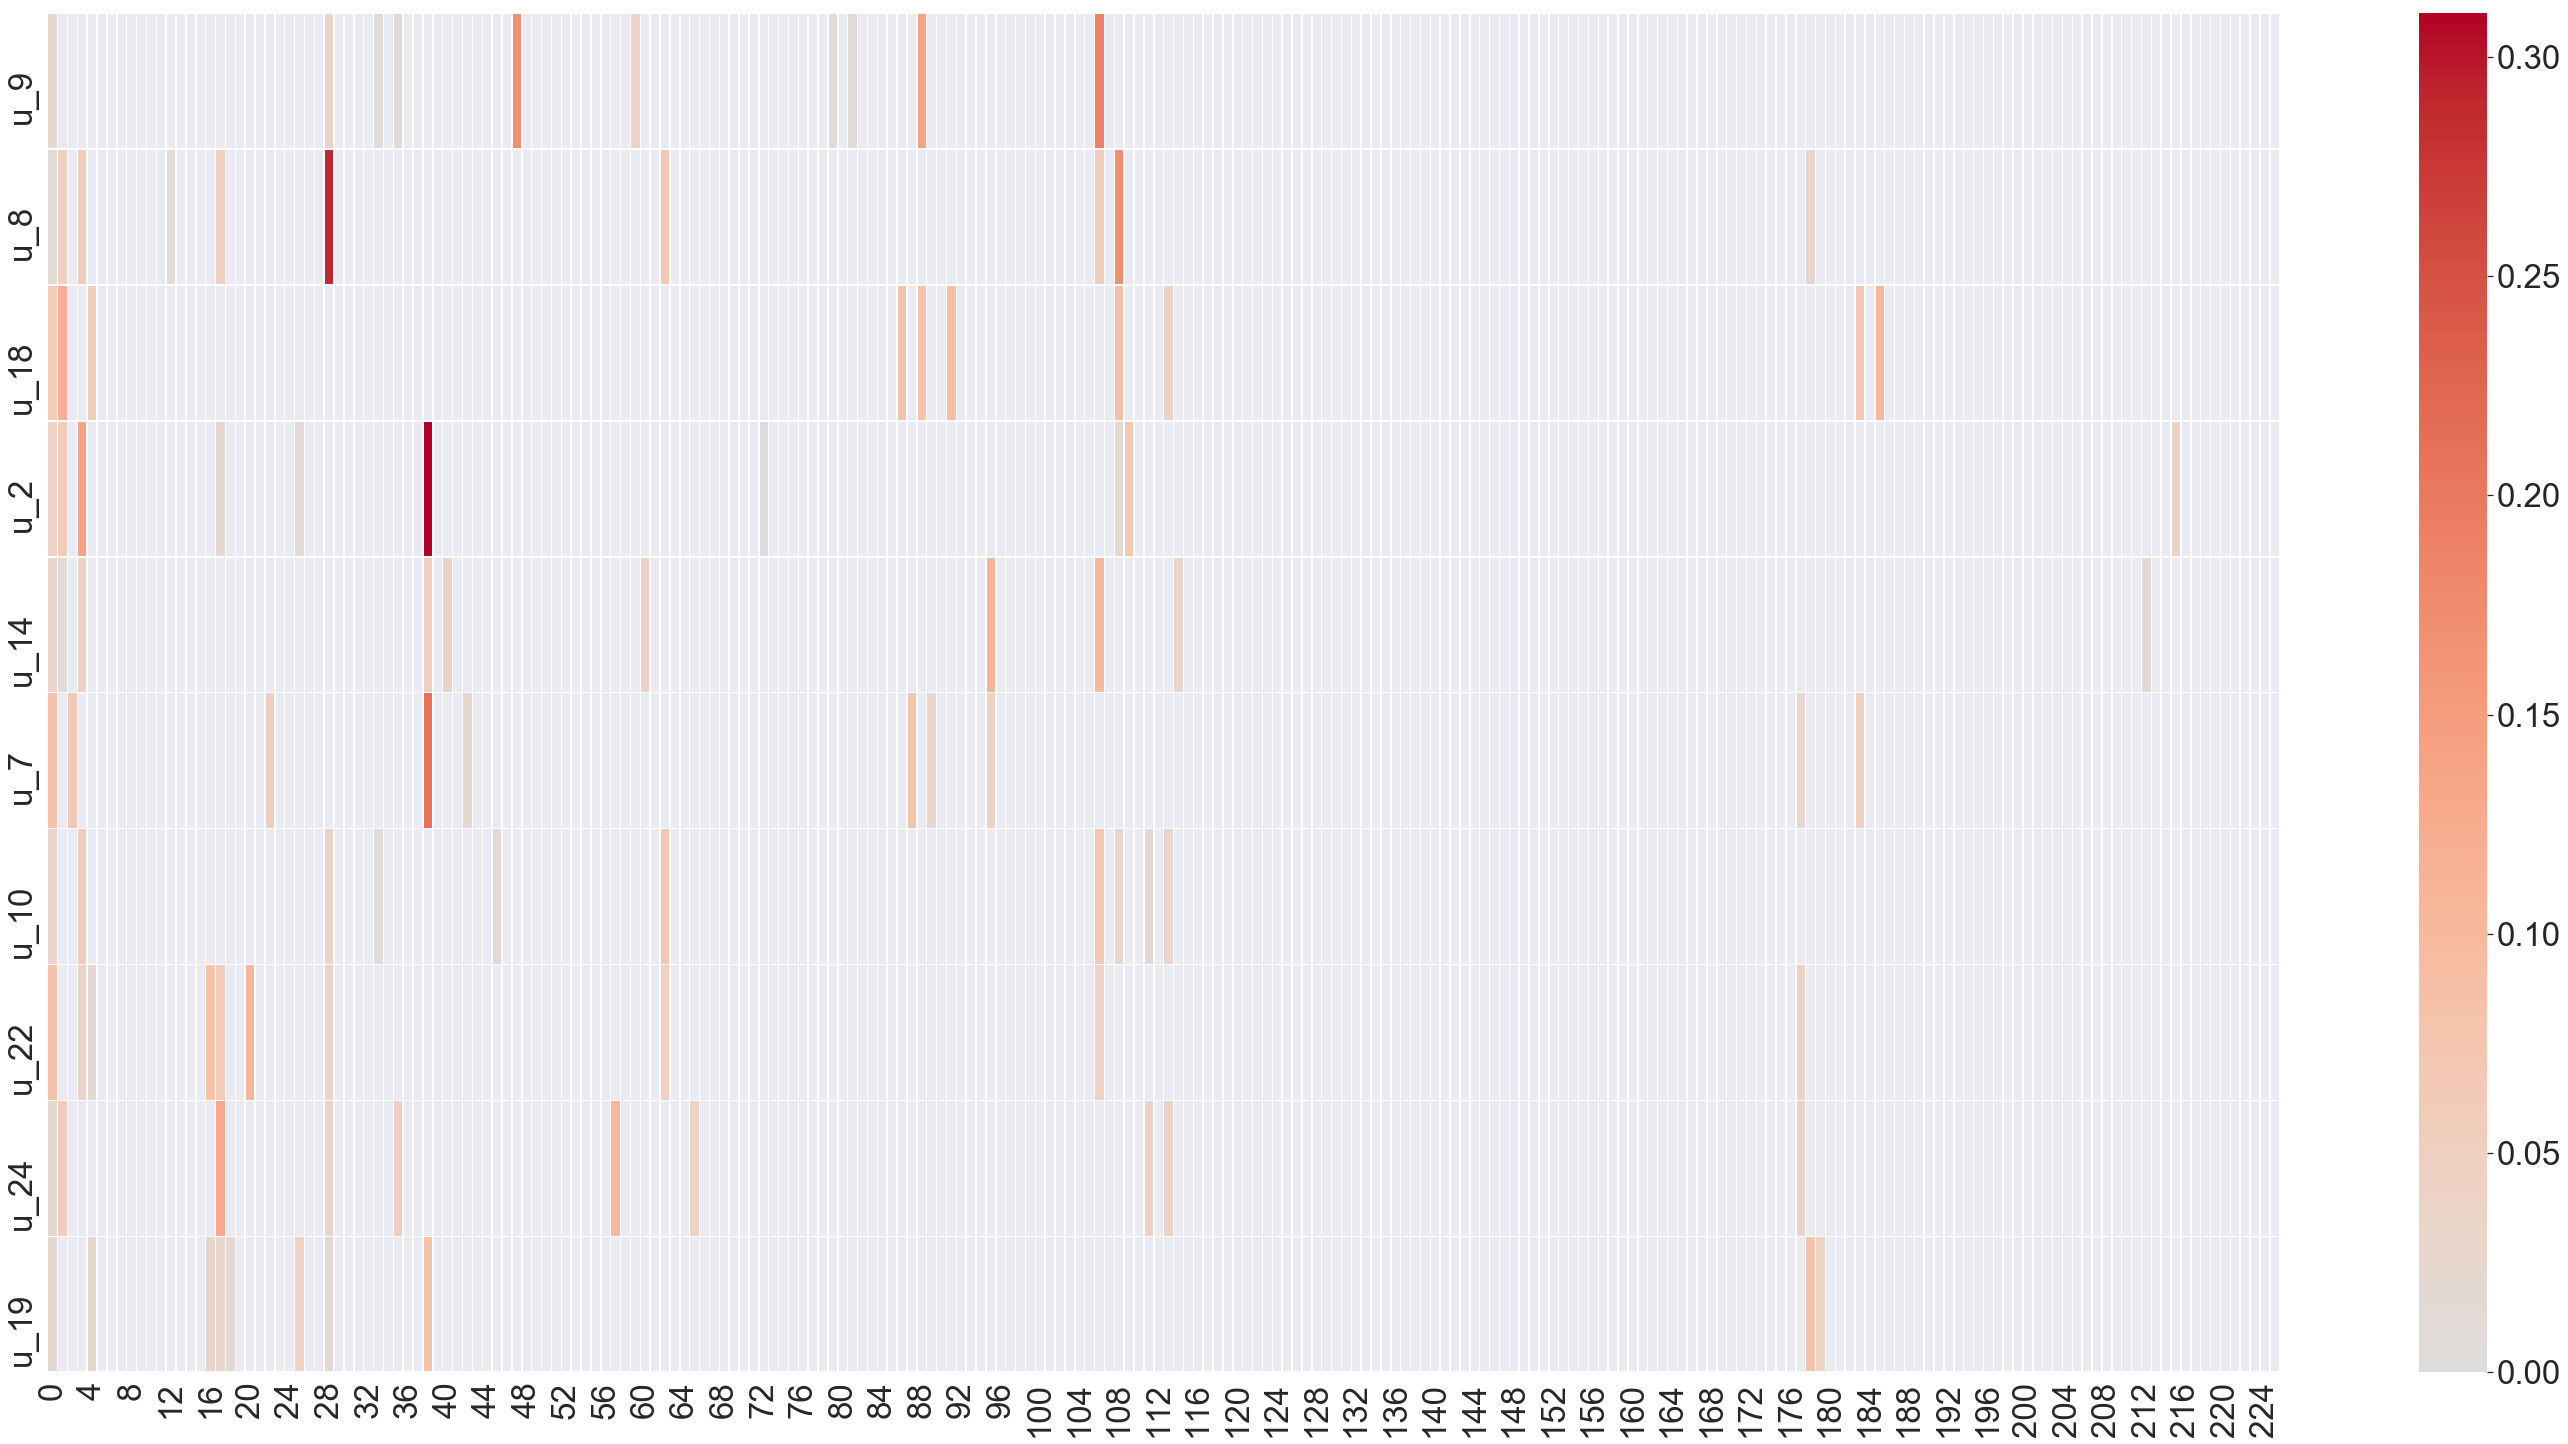

In [55]:
### top-10 features
k=10
ctn=0
for c in conditions:
    models,users = read_pickles("Model/"+c+"/")

    cond = "Transaction" if c =='TR' else c
    X = np.array([np.round(models["user_"+user.split('_')[1]+'_'+cond+'.pickle'].coef_,2) for user in sort[c]])
    

    top_10_idx = np.array([np.round(models["user_"+user.split('_')[1]+'_'+cond+'.pickle'].coef_,2).argsort()[::-1][:k] for user in sort[c]])
    ctn += sum(top_10_idx < 6)
    
    ### top-10 mask
    mask = np.ones(X.shape)
    for index,values in enumerate(mask):
        mask[index][top_10_idx[index]] = np.zeros(k)
    
    fig, ax = plt.subplots(figsize=(50,25)) 
    sns.set(font_scale=3)
    heat = sns.heatmap(X,linewidths=.5,cmap="coolwarm",yticklabels=sort[c],mask=mask,center=0.0)
    
    plt.savefig("figure\\features_"+c+".pdf",dpi=600,format="pdf")

# Click Frequency (appendix)

defaultdict(<class 'list'>, {'mean': [2.6, 1.0, 3.5, 2.8], 'std': [2.3664319132398464, 1.4142135623730951, 3.0276503540974917, 2.6997942308422114]})


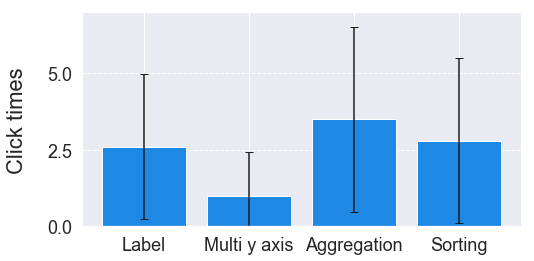

In [56]:
base_datas = {
    'label':[7,5,2,0,0,2,2,0,4,4],
    'yaxis':[0,4,2,0,0,0,0,0,2,2],
    'aggre':[7,3,8,0,0,0,3,7,3,4],
    'sort':[0,6,0,0,0,5,7,3,3,4]
}
drawBarFre(base_datas,'Click times')

## Count how many top-3 recommendation charts are be selected

In [19]:
import numpy as np
import matplotlib.pyplot as plt

data = readFile("VisGuide\\all")

In [20]:
user_data =defaultdict(dict)
num_label = defaultdict(list)
tree_num = []
total = []

for user,chart_data in data.items():

    tree_num.append(len(chart_data["store_structure"]))
    type1_top_select = {"Charts" : 0,
                        "Rank" : np.zeros((4,), dtype=int)}
    type2_top_select = {"Charts" : 0,
                        "Rank" : np.zeros((4,), dtype=int)}

    for label_data in chart_data['store_label_data']:#一個round
        if "rec" in label_data:
            rec_data = label_data["rec"]
        else:
            rec_data = copy.deepcopy(chart_data['store_chart_data'][label_data["chart"]]["rec"][str(label_data["key"])])
        
        #get info from chart datas
        type1 = rec_data["type1"]
        type2 = rec_data["type2"]
        
        type1_label = [chart["label"] for chart in type1]
        type2_label = [chart["label"] for chart in type2]
        print(user,type1_label,type2_label)
        if sum(type1_label) != 0:
            for i in range(len(type1_label)):
                try:
                    if i<3:
                        if type1_label[i] == 0.6:
                            type1_top_select["Rank"][i] += 1
                            type1_top_select["Charts"] += 1
                    else:
                        if type1_label[i] == 0.6:
                            type1_top_select["Rank"][3] += 1
                            type1_top_select["Charts"] += 1
                except:
                    pass
        if sum(type2_label) != 0:
            for i in range(len(type2_label)):   
                try:
                    if i<3:
                        if type2_label[i] == 0.6:
                            type2_top_select["Rank"][i] += 1
                            type2_top_select["Charts"] += 1
                    else:
                        if type2_label[i] == 0.6:
                            type2_top_select["Rank"][3] += 1
                            type2_top_select["Charts"] += 1
                except:
                    pass

    total.append([user,type1_top_select["Charts"],type1_top_select["Rank"],type2_top_select["Charts"],type2_top_select["Rank"]])        

user_10_AQ.json [0.6, 0.6, 0, 0.6, 0.6] [0.6, 0, 0]
user_10_AQ.json [0, 0, 0, 0, 0] [0, 0]
user_10_AQ.json [0.6, 0, 0.6, 0.6, 0.6] [0, 0]
user_10_AQ.json [0.3, 0.3, 0.3, 0.6] [0, 0]
user_10_AQ.json [0.3, 0.3, 0.6, 0] [0, 0]
user_10_AQ.json [0.6, 0, 0, 0] [0, 0]
user_10_AQ.json [0, 0, 0.6, 0] [0, 0]
user_10_AQ.json [0.6, 0, 0, 0] [0, 0]
user_10_AQ.json [0, 0.6, 0, 0.6] [0, 0]
user_10_AQ.json [0.6, 0, 0.6, 0] [0, 0, 0]
user_10_AQ.json [0, 0.6, 0, 0] [0, 0, 0]
user_10_AQ.json [0, 0, 0, 0] [0, 0, 0]
user_10_AQ.json [0, 0, 0.6, 0] [0, 0]
user_10_AQ.json [0.6, 0, 0, 0] [0, 0, 0]
user_10_AQ.json [0, 0.6, 0, 0.6] [0, 0]
user_10_AQ.json [0, 0, 0, 0.6, 0] [0.6, 0.6, 0.6]
user_10_AQ.json [0.6, 0, 0, 0, 0] []
user_10_AQ.json [0.6, 0, 0, 0, 0] []
user_10_Transaction.json [0, 0, 0, 0, 0, 0, 0, 0] [0, 0]
user_10_Transaction.json [0.6, 0, 0, 0.6, 0, 0, 0, 0] [0, 0]
user_10_Transaction.json [0.6, 0, 0, 0.6, 0, 0, 0, 0] [0, 0]
user_10_Transaction.json [0, 0, 0, 0, 0, 0, 0, 0] [0, 0.6]
user_10_Transactio

In [21]:
# user, type1 round, type1[first, second, third], type2 round, type2[first, second, third]
total

[['user_10_AQ.json', 25, array([8, 4, 5, 8]), 4, array([2, 1, 1, 0])],
 ['user_10_Transaction.json', 10, array([4, 2, 1, 3]), 1, array([0, 1, 0, 0])],
 ['user_14_AQ.json', 20, array([9, 0, 3, 8]), 16, array([10,  3,  3,  0])],
 ['user_14_Transaction.json', 18, array([3, 5, 2, 8]), 2, array([2, 0, 0, 0])],
 ['user_18_AQ.json', 13, array([9, 3, 0, 1]), 12, array([4, 4, 4, 0])],
 ['user_18_Transaction.json', 11, array([6, 2, 0, 3]), 4, array([4, 0, 0, 0])],
 ['user_19_AQ.json', 18, array([8, 5, 3, 2]), 3, array([3, 0, 0, 0])],
 ['user_19_Transaction.json', 16, array([2, 4, 3, 7]), 0, array([0, 0, 0, 0])],
 ['user_22_AQ.json', 8, array([4, 2, 2, 0]), 12, array([4, 4, 4, 0])],
 ['user_22_Transaction.json', 8, array([0, 4, 2, 2]), 3, array([2, 1, 0, 0])],
 ['user_24_AQ.json', 14, array([6, 1, 2, 5]), 17, array([7, 6, 4, 0])],
 ['user_24_Transaction.json', 10, array([3, 0, 0, 7]), 1, array([1, 0, 0, 0])],
 ['user_2_AQ.json', 8, array([7, 0, 0, 1]), 5, array([3, 1, 1, 0])],
 ['user_2_Transacti

In [67]:
AQ_top3_data = {}
TR_top3_data = {}
two_top3_data = {}
label = ["1st","2nd","3rd","Others"]
tmp1 = [[],[],[],[]]
tmp2 = [[],[],[],[]]
for i in range(len(total)):
    if i%2 == 0:
        for j in range(4):
            #tmp1[j].append(round(total[i][2][j]/total[i][1],2))
            tmp1[j].append(round((total[i][2][j]+total[i][4][j])/(total[i][1]+total[i][3]),2))
            #if total[i][3] != 0:
            #    tmp1[j+4].append(round(total[i][4][j]/total[i][3],2))
            #else:
            #    tmp1[j+4].append(0)
    else:
        for j in range(4):
            #tmp2[j].append(round(total[i][2][j]/total[i][1],2))
            tmp2[j].append(round((total[i][2][j]+total[i][4][j])/(total[i][1]+total[i][3]),2))
            #if total[i][3] != 0:
            #    tmp2[j+4].append(round(total[i][4][j]/total[i][3],2))
            #else:
            #    tmp2[j+4].append(0)

for i in range(4):
    AQ_top3_data[label[i]] = tmp1[i]
    TR_top3_data[label[i]] = tmp2[i]
    two_top3_data[label[i]] = [round((a+b)/2,2) for a, b in zip(tmp1[i], tmp2[i])]

In [68]:
AQ_top3_data

{'1st': [0.34, 0.53, 0.52, 0.52, 0.4, 0.42, 0.77, 0.1, 0.69, 0.4],
 '2nd': [0.17, 0.08, 0.28, 0.24, 0.3, 0.23, 0.08, 0.45, 0.08, 0.3],
 '3rd': [0.21, 0.17, 0.16, 0.14, 0.3, 0.19, 0.08, 0.15, 0.12, 0.2],
 'Others': [0.28, 0.22, 0.04, 0.1, 0.0, 0.16, 0.08, 0.3, 0.12, 0.1]}

In [69]:
TR_top3_data

{'1st': [0.36, 0.25, 0.67, 0.12, 0.18, 0.36, 0.58, 0.36, 0.8, 0.75],
 '2nd': [0.27, 0.25, 0.13, 0.25, 0.45, 0.0, 0.08, 0.21, 0.13, 0.0],
 '3rd': [0.09, 0.1, 0.0, 0.19, 0.18, 0.0, 0.0, 0.0, 0.07, 0.0],
 'Others': [0.27, 0.4, 0.2, 0.44, 0.18, 0.64, 0.33, 0.43, 0.0, 0.25]}

In [70]:
two_top3_data

{'1st': [0.35, 0.39, 0.6, 0.32, 0.29, 0.39, 0.68, 0.23, 0.74, 0.57],
 '2nd': [0.22, 0.16, 0.2, 0.24, 0.38, 0.12, 0.08, 0.33, 0.11, 0.15],
 '3rd': [0.15, 0.14, 0.08, 0.16, 0.24, 0.1, 0.04, 0.08, 0.1, 0.1],
 'Others': [0.28, 0.31, 0.12, 0.27, 0.09, 0.4, 0.2, 0.36, 0.06, 0.18]}

In [75]:
def drawBarTop3Fre(datas,ylabel,dataset=""):
    fig = plt.figure(figsize=(cm2inch(20,10)))
    fig.tight_layout()
       
    draw_data = defaultdict(list)
  
    for condition,values in datas.items():
        draw_data["mean"].append(scipy.mean(values))
        draw_data["std"].append(statistics.stdev(values))

    ax1 = plt.subplot(1,1,1)    
        
    ax1.set_ylabel(ylabel,fontsize=22,labelpad=20)

    ind = np.arange(len(draw_data["mean"]))  
    plt.yticks(fontsize=18)
    plt.xticks(ind,fontsize=12)
    plt.ylim([0,1])
    ax1.set_xticklabels(["1st","2nd","3rd","others"])
    
    
    ax1.bar(ind, draw_data["mean"],yerr=draw_data["std"],capsize=4)
    plt.grid(linestyle='--',axis="y")
    plt.title("Pick rate of top3 recommendation charts "+dataset,fontsize=20)
    print(draw_data)
    
    #plt.savefig("figure\\Top3_Fre.pdf",dpi=600,format="pdf")
    #plt.savefig("figure\\Top3_Fre.png",dpi=600,format="png")

defaultdict(<class 'list'>, {'mean': [0.46900000000000003, 0.221, 0.172, 0.14000000000000004], 'std': [0.18651481919080257, 0.12068784344562446, 0.059404451759854565, 0.0993310961716756]})


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  


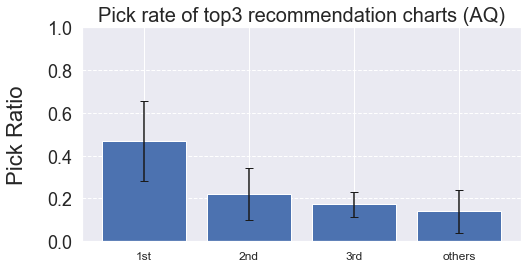

In [76]:
drawBarTop3Fre(AQ_top3_data,'Pick Ratio','(AQ)')

defaultdict(<class 'list'>, {'mean': [0.44299999999999995, 0.177, 0.06300000000000001, 0.314], 'std': [0.24115693368980018, 0.1380056359557665, 0.07587270040447135, 0.17601767588007242]})


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  


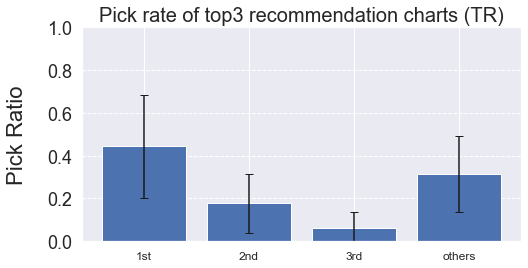

In [77]:
drawBarTop3Fre(TR_top3_data,'Pick Ratio','(TR)')

defaultdict(<class 'list'>, {'mean': [0.45600000000000007, 0.199, 0.11900000000000002, 0.22700000000000004], 'std': [0.17689921801221545, 0.09677580046455599, 0.055866905329641364, 0.11557104597028907]})


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  


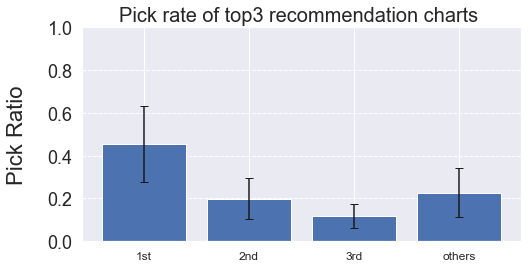

In [79]:
drawBarTop3Fre(two_top3_data,'Pick Ratio')